### <center> **Advanced Statistics - Education Analysis** </center>

---

**<center> Author: Aravindan Natarajan </center>**
**<center>Version: 2.0</center>**

---

### **Data Summary**

The dataset Education - Post 12th Standard.csv contains information on various colleges. The data dictionary of the Education - Post 12th Standard.csv can be found in the following file: Data Dictionary.xlsx.

**<center>Data Dictionary</center>**

---

| S.No. | Column Name | Description                                         |
|-------|-------------|-----------------------------------------------------|
| 1     | Names       | Names of various university and colleges             |
| 2     | Apps        | Number of applications received                     |
| 3     | Accept      | Number of applications accepted                     |
| 4     | Enroll      | Number of new students enrolled                     |
| 5     | Top10perc   | Percentage of new students from top 10% of High School |
| 6     | Top25perc   | Percentage of new students from top 25% of High School |
| 7     | F.Undergrad | Number of full-time undergraduate students          |
| 8     | P.Undergrad | Number of part-time undergraduate students          |
| 9     | Outstate    | Number of students for whom the particular college is out of state |
| 10    | Room.Board  | Cost of Room and board                               |
| 11    | Books       | Estimated book costs for a student                  |
| 12    | Personal    | Estimated personal spending for a student           |
| 13    | PhD         | Percentage of faculties with Ph.D.’s                 |
| 14    | Terminal    | Percentage of faculties with terminal degree        |
| 15    | S.F.Ratio   | Student/faculty ratio                             |
| 16    | perc.alumni | Percentage of alumni who donate                     |
| 17    | Expend      | The Instructional expenditure per student           |
| 18    | Grad.Rate   | Graduation rate                                     |

---

Following are the objectives for this analysis:

* Perform Exploratory Data Analysis and insights from it

* Outlier analysis before and after scaling

* Perform Principle Component Analysis (PCA) and understand the impact of scaling on it.

* Extract the eigenvalues and eigenvectors

* Compare the covariance and the correlation matrices for the scled data

* Explain the business implication of using Principal Component Analysis for this case study

### **1. Import the Required Libraries**

In [18]:
# Import basic packages
import pandas as pd
import numpy as np
import itertools

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
sns.set(style='ticks', color_codes=True)
%matplotlib inline

# Set colour palette
palette = itertools.cycle(sns.color_palette())

# Import statistical packages
import statsmodels.api as sm
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Warning handling
import warnings
warnings.filterwarnings("ignore")

### **2. Some Useful Functions**

In [19]:
# Annotation function to display the numbers above bar for bargraphs

def annotate_values(ax, orientation='v'):
  # Display counts at the top of the bars
  for p in ax.patches:
        if orientation == 'v':
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=8)

        elif orientation == 'h':
            ax.annotate(format(p.get_width(), '.0f'),
                        (p.get_width(), p.get_y() + p.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points',
                        fontsize=8)

In [20]:
# Function for plotting a countplot

def plot_countplot(df, column, hue=None, hue_order=None):
  plt.figure(figsize=(10, 6))

  # If hue is provided, use it in the countplot
  if hue:
    counts = df.groupby([column, hue]).size().reset_index(name='count')
    order = counts.sort_values('count', ascending=False)[column].unique()
    ax = sns.countplot(x=column, data=df, order=order, hue=hue, hue_order=hue_order)
  else:
    counts = df[column].value_counts().sort_values(ascending=False)
    ax = sns.countplot(x=column, data=df, order=counts.index)

  plt.xticks(rotation=90)
  plt.title(f'Count Plot of {column}')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Count of {column}')
  annotate_values(ax)
  plt.show()

In [21]:
# Function similar to plot_countplot named as plot_barplot

def plot_barplot(df, x_col, y_col, hue=None, hue_order=None):
    plt.figure(figsize=(10, 6))

    # Sort x_col values in ascending order
    order = df[x_col].sort_values().unique()

    if hue:
        ax = sns.barplot(x=x_col, y=y_col, data=df, hue=hue, hue_order=hue_order, order=order, palette='Set1',ci=None)  # ci=None removes error bars
    else:
        ax = sns.barplot(x=x_col, y=y_col, data=df, order=order, palette='Set1', ci=None)

    plt.xticks(rotation=90)
    plt.title(f'Bar Plot of {y_col} vs {x_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    annotate_values(ax)
    plt.show()

In [22]:
# Function to annotate a Seaborn box plot with quartiles, IQR, maximum, and minimum values.

def annotate_boxplot(data_series, ax=None):

    # Calculate quartiles and IQR
    q1, q2, q3 = data_series.quantile([0.25, 0.5, 0.75])
    iqr = q3 - q1

    # Get minimum and maximum values
    data_min = data_series.min()
    data_max = data_series.max()

    # Get plot limits
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min

    # Adjust figure size based on x-range
    fig = plt.gcf()
    fig.set_size_inches(10 + x_range/20, 15)  # Adjust these values as needed

    # Annotate quartiles and IQR without arrows
    ax.text(q1, -0.3, f"Q1: {q1:.2f}", ha='center')
    ax.text(q2, 0.3, f"Q2 (Median): {q2:.2f}", ha='center')
    ax.text(q3, -0.4, f"Q3: {q3:.2f}", ha='center')
    #ax.text((q1+q3)/2, 0.3, f"IQR: {iqr:.2f}", ha='center', va='center')

    # Annotate minimum and maximum without arrows
    ax.text(data_min, -0.2, f"Min: {data_min:.2f}", ha='center')
    ax.text(data_max, 0.1, f"Max: {data_max:.2f}", ha='center')

    return ax

In [23]:
# Detects outliers in all specified columns of a DataFrame using the IQR method

def detect_outliers_iqr(df, col_list):

    # Calculate IQR
    Q1 = df[num_col_list].quantile(0.25)
    Q3 = df[num_col_list].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # Create outlier dataframe
    outlier_df = pd.DataFrame()
    outlier_df['% Upper Outlier'] = ((df[num_col_list] > upper_limit).sum() / len(df) * 100).round(2)
    outlier_df['% Lower Outlier'] = ((df[num_col_list] < lower_limit).sum() / len(df) * 100).round(2)
    outlier_df['% Total Outlier'] = (outlier_df['% Upper Outlier'] + outlier_df['% Lower Outlier']).round(2)

    # Sort by total outlier percentage
    outlier_df = outlier_df.sort_values(by='% Total Outlier', ascending=False)

    return outlier_df

### **3. Import the Dataset**

In [24]:
# Load the dataset
edu_df= pd.read_csv(r'../data/Education_Post_12th_Standard.csv')
edu_df.head()

Names  Apps  Accept  Enroll  Top10perc  Top25perc  \
0  Abilene Christian University  1660    1232     721         23         52   
1            Adelphi University  2186    1924     512         16         29   
2                Adrian College  1428    1097     336         22         50   
3           Agnes Scott College   417     349     137         60         89   
4     Alaska Pacific University   193     146      55         16         44   

   F.Undergrad  P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  \
0         2885          537      7440        3300    450      2200   70   
1         2683         1227     12280        6450    750      1500   29   
2         1036           99     11250        3750    400      1165   53   
3          510           63     12960        5450    450       875   92   
4          249          869      7560        4120    800      1500   76   

   Terminal  S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0        78       18.1           12    7041         60  
1        30       12.2           16   10527         56  
2        66       12.9           30    8735         54  
3        97        7.7           37   19016         59  
4        72       11.9            2   10922         15

### **3. Exploratory Data Analysis**

In [25]:
rows, cols = edu_df.shape
print('There are {} rows and {} columns in the datset'.format(rows,cols))

There are 777 rows and 18 columns in the datset


In [26]:
# Information about the dataset
edu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Names        777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16), object(1)
memory usage: 

In [27]:
# Check for null values
edu_df.isnull().any()

Names          False
Apps           False
Accept         False
Enroll         False
Top10perc      False
Top25perc      False
F.Undergrad    False
P.Undergrad    False
Outstate       False
Room.Board     False
Books          False
Personal       False
PhD            False
Terminal       False
S.F.Ratio      False
perc.alumni    False
Expend         False
Grad.Rate      False
dtype: bool

In [28]:
# Check if there are any duplicate entries
edu_df.duplicated().any()

False

**Summary**
* The dataset has 777 entries and 18 columns.
* There are no missing values in the dataset.
* All columns except 'Names' are numeric (int64 or float64).
* 'Names' is the only categorical column of type object (string).
* There are no duplicate entries present in the rows

#### **3a. Univariate Analysis**

In [29]:
# Convert column names to a list for ease of plotting
num_col_list = edu_df.select_dtypes(include=np.number).columns.tolist()
num_col_list

['Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F.Undergrad',
 'P.Undergrad',
 'Outstate',
 'Room.Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S.F.Ratio',
 'perc.alumni',
 'Expend',
 'Grad.Rate']

In [30]:
# Statistical summary of the dataset
edu_stat_df = edu_df.describe().T
edu_stat_df['Skew']=edu_df[num_col_list].skew(axis=0)
edu_stat_df['Kurtosis']=edu_df[num_col_list].kurtosis(axis=0)
edu_stat_df

count          mean          std     min     25%     50%  \
Apps         777.0   3001.638353  3870.201484    81.0   776.0  1558.0   
Accept       777.0   2018.804376  2451.113971    72.0   604.0  1110.0   
Enroll       777.0    779.972973   929.176190    35.0   242.0   434.0   
Top10perc    777.0     27.558559    17.640364     1.0    15.0    23.0   
Top25perc    777.0     55.796654    19.804778     9.0    41.0    54.0   
F.Undergrad  777.0   3699.907336  4850.420531   139.0   992.0  1707.0   
P.Undergrad  777.0    855.298584  1522.431887     1.0    95.0   353.0   
Outstate     777.0  10440.669241  4023.016484  2340.0  7320.0  9990.0   
Room.Board   777.0   4357.526384  1096.696416  1780.0  3597.0  4200.0   
Books        777.0    549.380952   165.105360    96.0   470.0   500.0   
Personal     777.0   1340.642214   677.071454   250.0   850.0  1200.0   
PhD          777.0     72.660232    16.328155     8.0    62.0    75.0   
Terminal     777.0     79.702703    14.722359    24.0    71.0    82.0   
S.F.Ratio    777.0     14.089704     3.958349     2.5    11.5    13.6   
perc.alumni  777.0     22.743887    12.391801     0.0    13.0    21.0   
Expend       777.0   9660.171171  5221.768440  3186.0  6751.0  8377.0   
Grad.Rate    777.0     65.463320    17.177710    10.0    53.0    65.0   

                 75%      max      Skew   Kurtosis  
Apps          3624.0  48094.0  3.723750  26.774253  
Accept        2424.0  26330.0  3.417727  18.938099  
Enroll         902.0   6392.0  2.690465   8.831544  
Top10perc       35.0     96.0  1.413217   2.208065  
Top25perc       69.0    100.0  0.259340  -0.564121  
F.Undergrad   4005.0  31643.0  2.610458   7.696586  
P.Undergrad    967.0  21836.0  5.692353  55.034518  
Outstate     12925.0  21700.0  0.509278  -0.413832  
Room.Board    5050.0   8124.0  0.477356  -0.187553  
Books          600.0   2340.0  3.485025  28.333097  
Personal      1700.0   6800.0  1.742497   7.124017  
PhD             85.0    103.0 -0.768170   0.564773  
Terminal        92.0    100.0 -0.816542   0.242019  
S.F.Ratio       16.5     39.8  0.667435   2.561209  
perc.alumni     31.0     64.0  0.606891  -0.096807  
Expend       10830.0  56233.0  3.459322  18.771500  
Grad.Rate       78.0    118.0 -0.113777  -0.205226

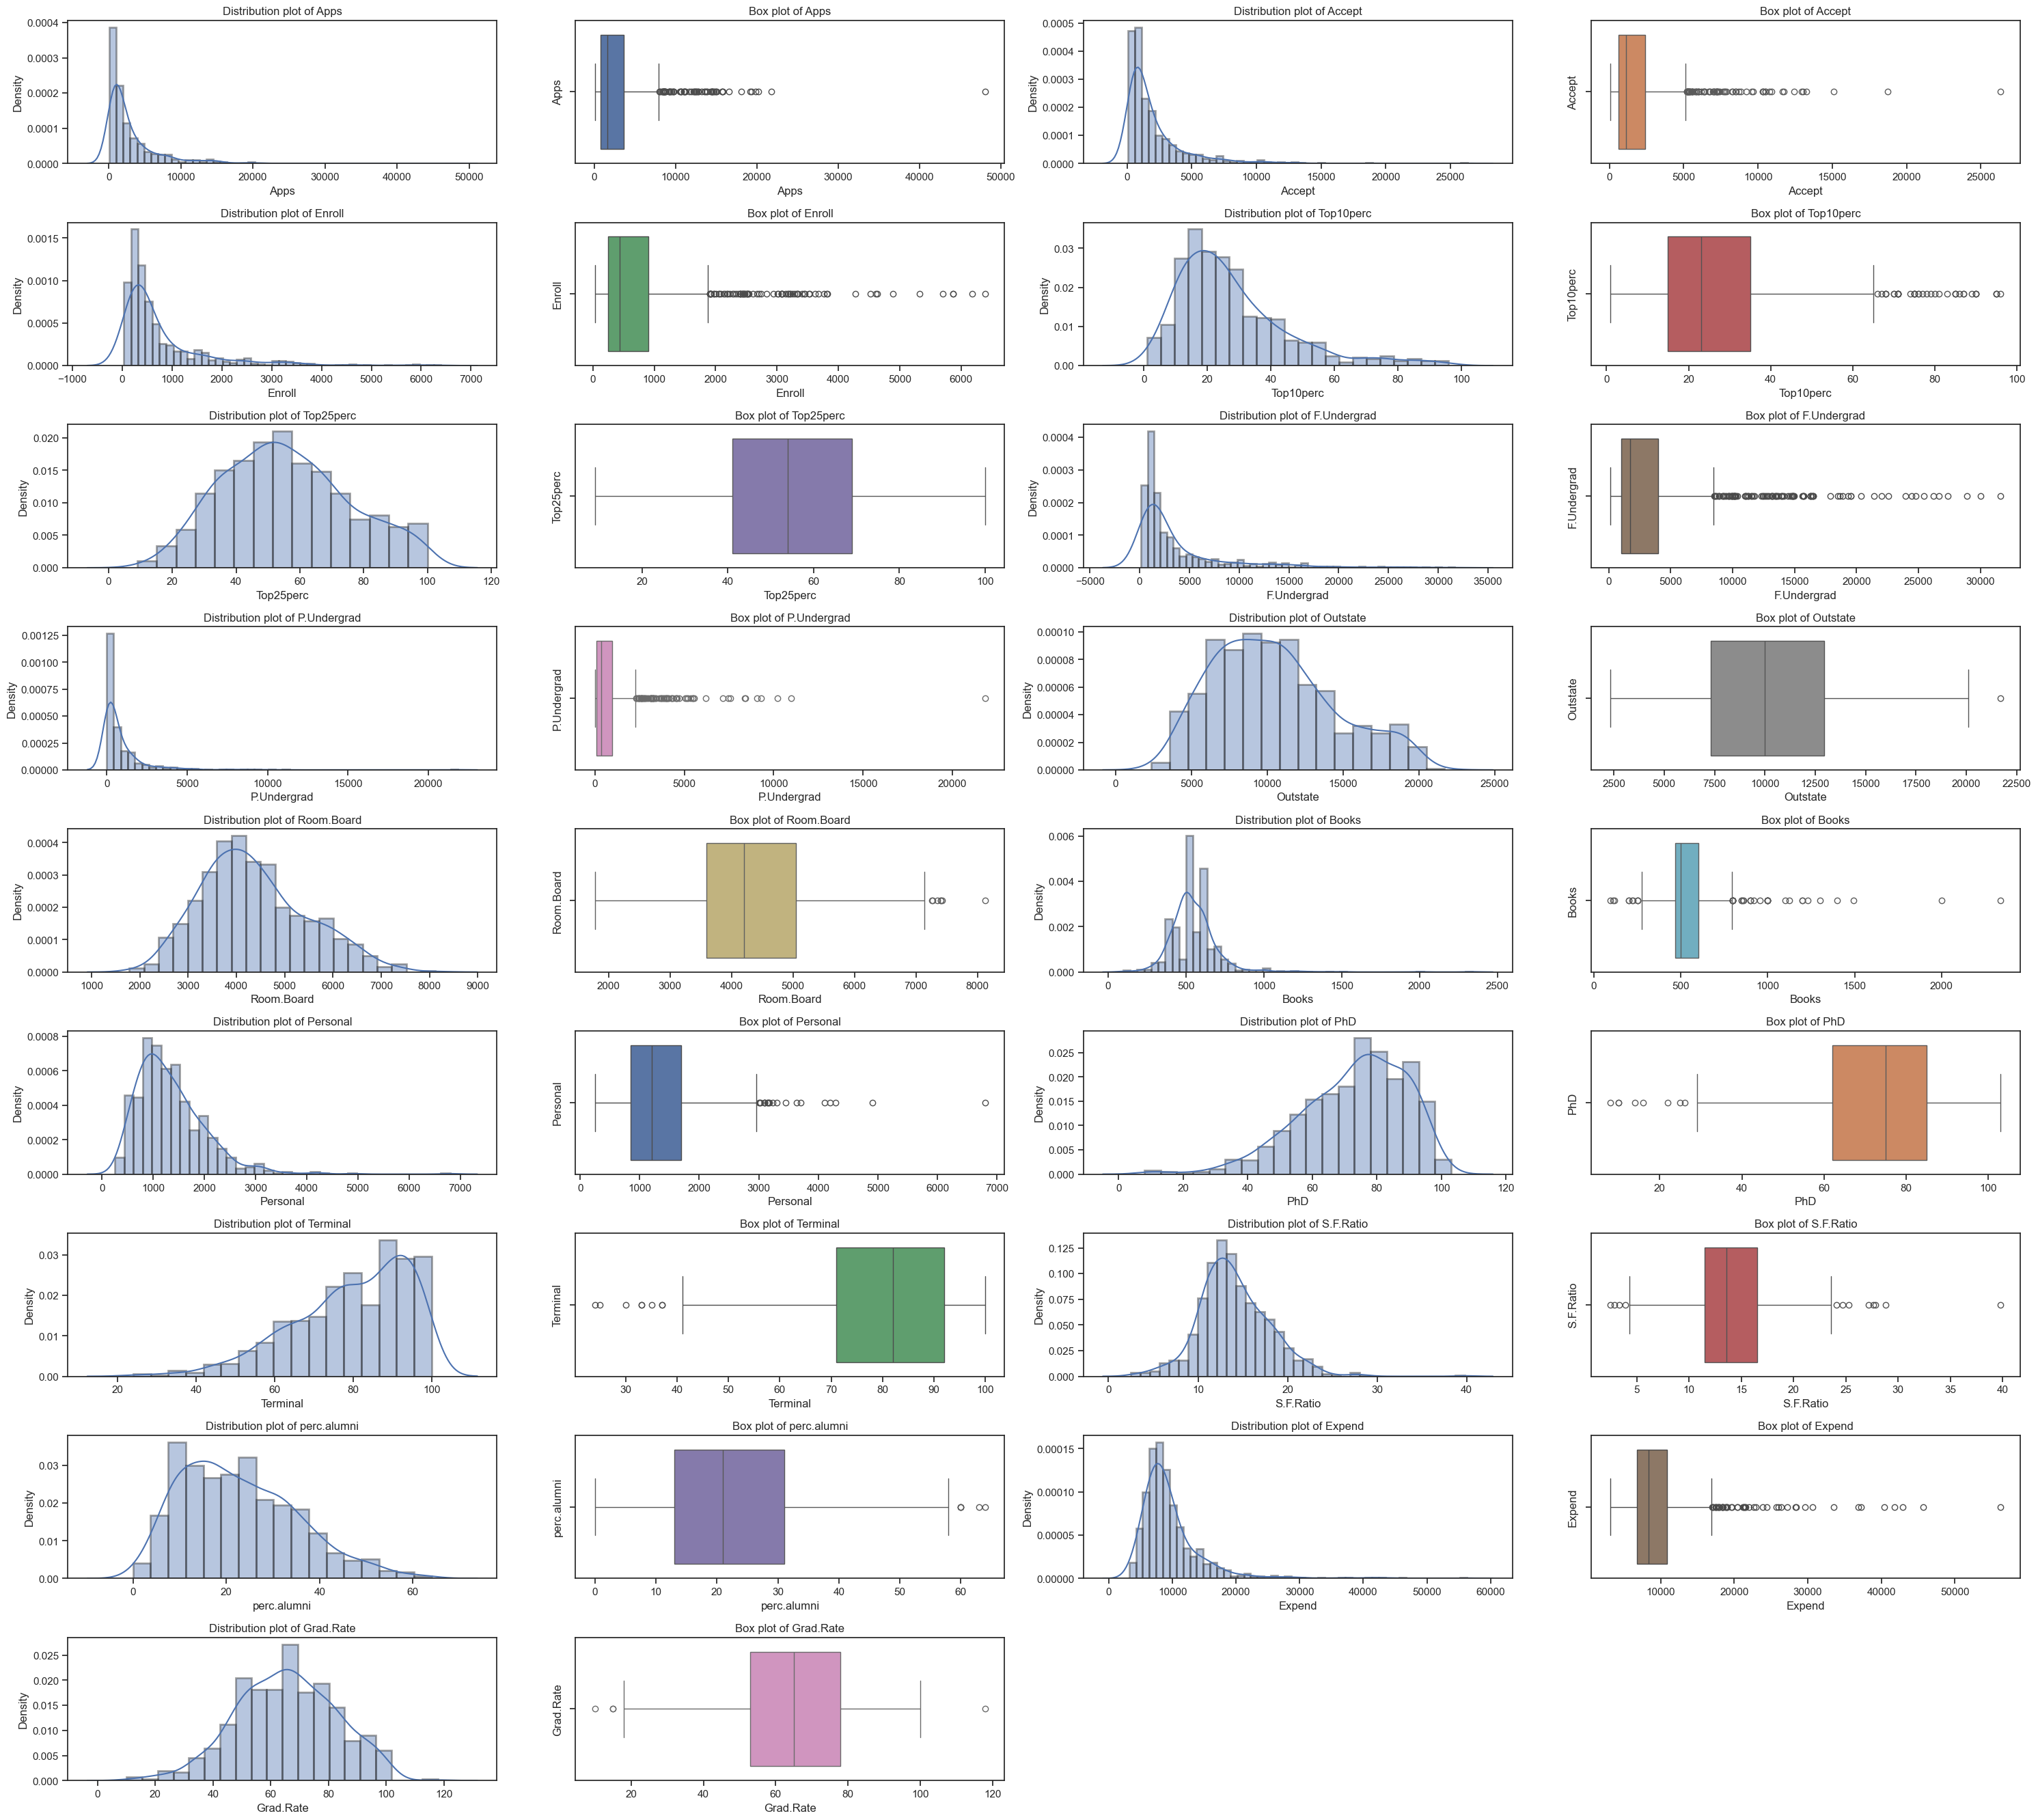

In [31]:
#  Plot all the numerical variables
a = len(num_col_list)  # number of rows
b = 4 # number of columns
c = 1  # initialize plot counter

fig13 = plt.figure(figsize=(30,50))

for i in num_col_list:
    plt.subplot(a, b, c)
    plt.title('Distribution plot of {}'.format(i))
    plt.xlabel(i)
    sns.distplot(edu_df[i], hist_kws=dict(edgecolor="k", linewidth=2))
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('Box plot of {}'.format(i))
    plt.ylabel(i)
    sns.boxplot(x = edu_df[i], orient='h', palette=palette)
    c = c + 1

plt.tight_layout()
plt.show()

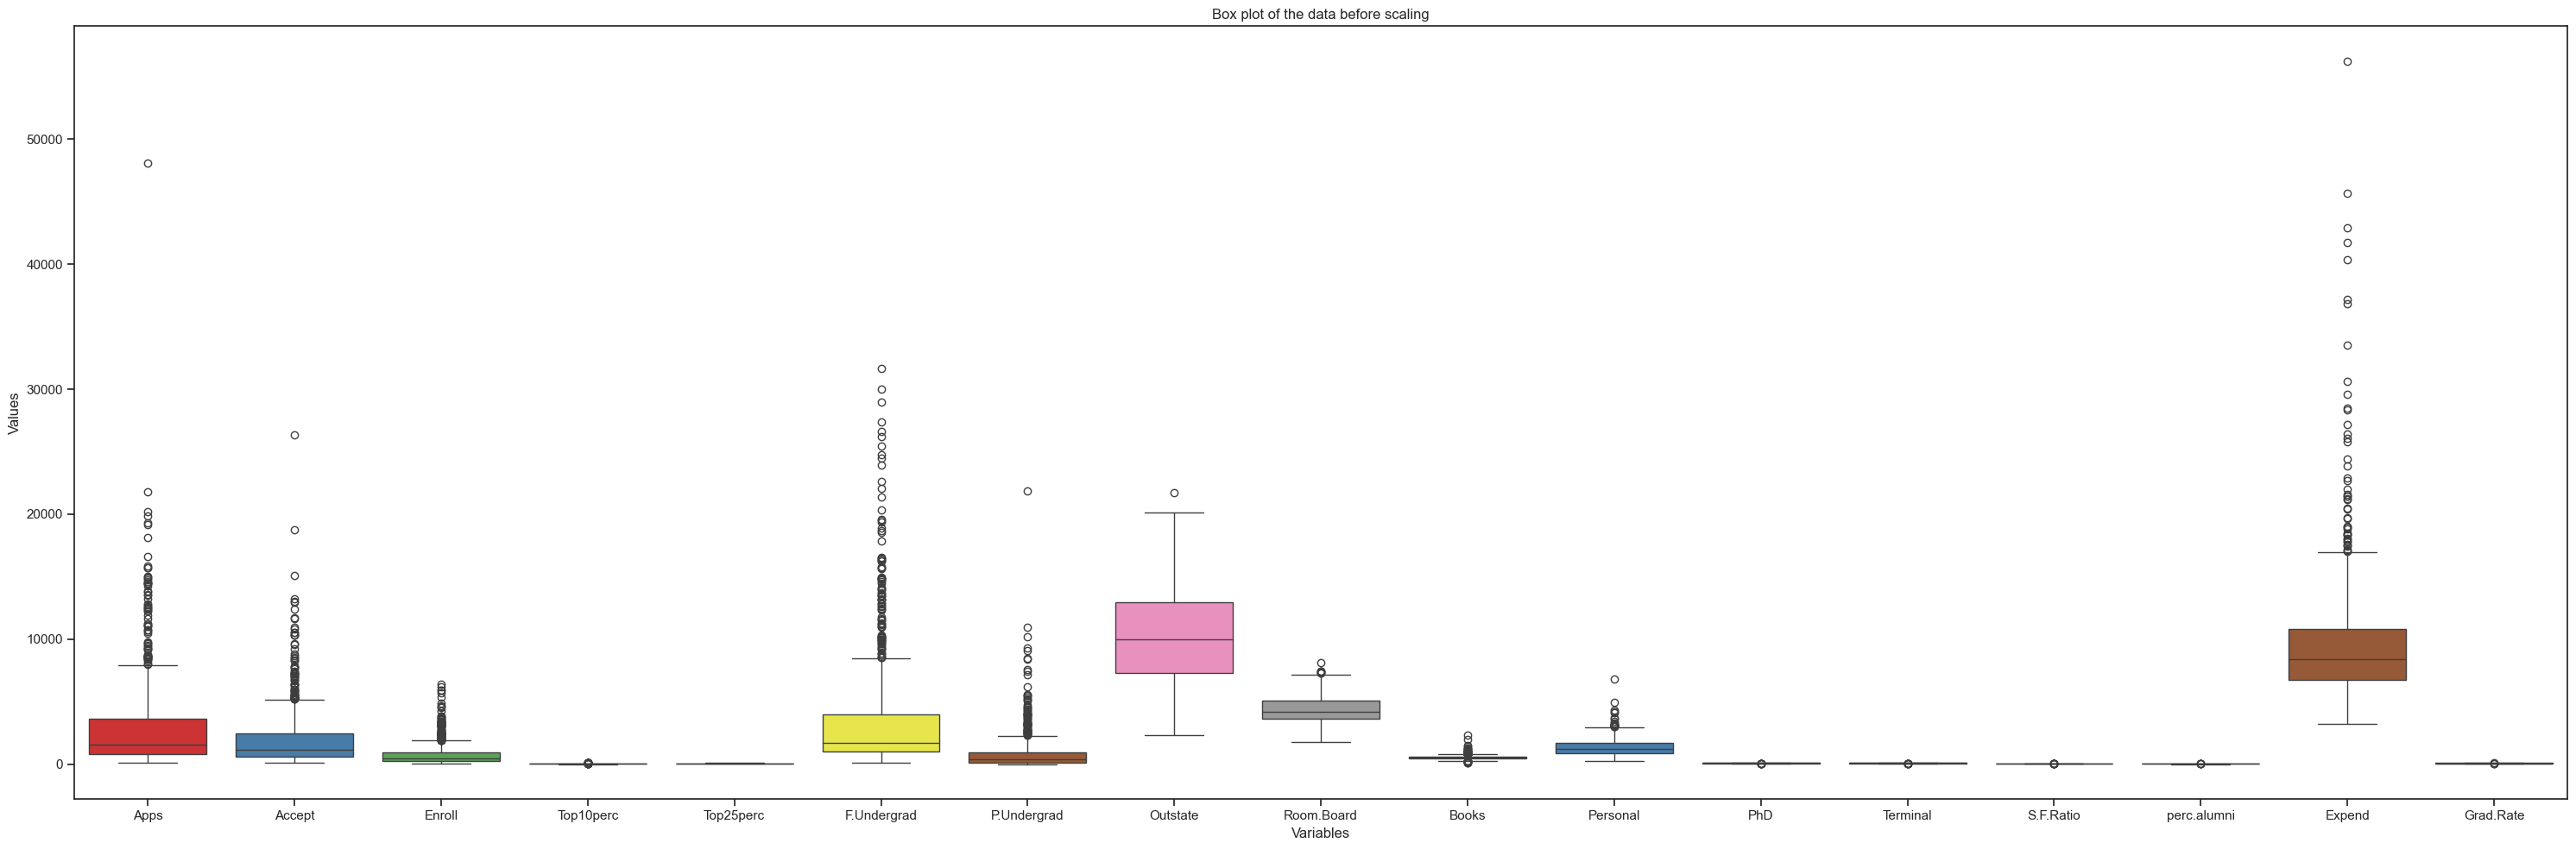

In [32]:
# Box plot of the data before scaling
plt.figure(figsize=(30,10))
sns.boxplot(data=edu_df[num_col_list], palette='Set1');
plt.title('Box plot of the data before scaling')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

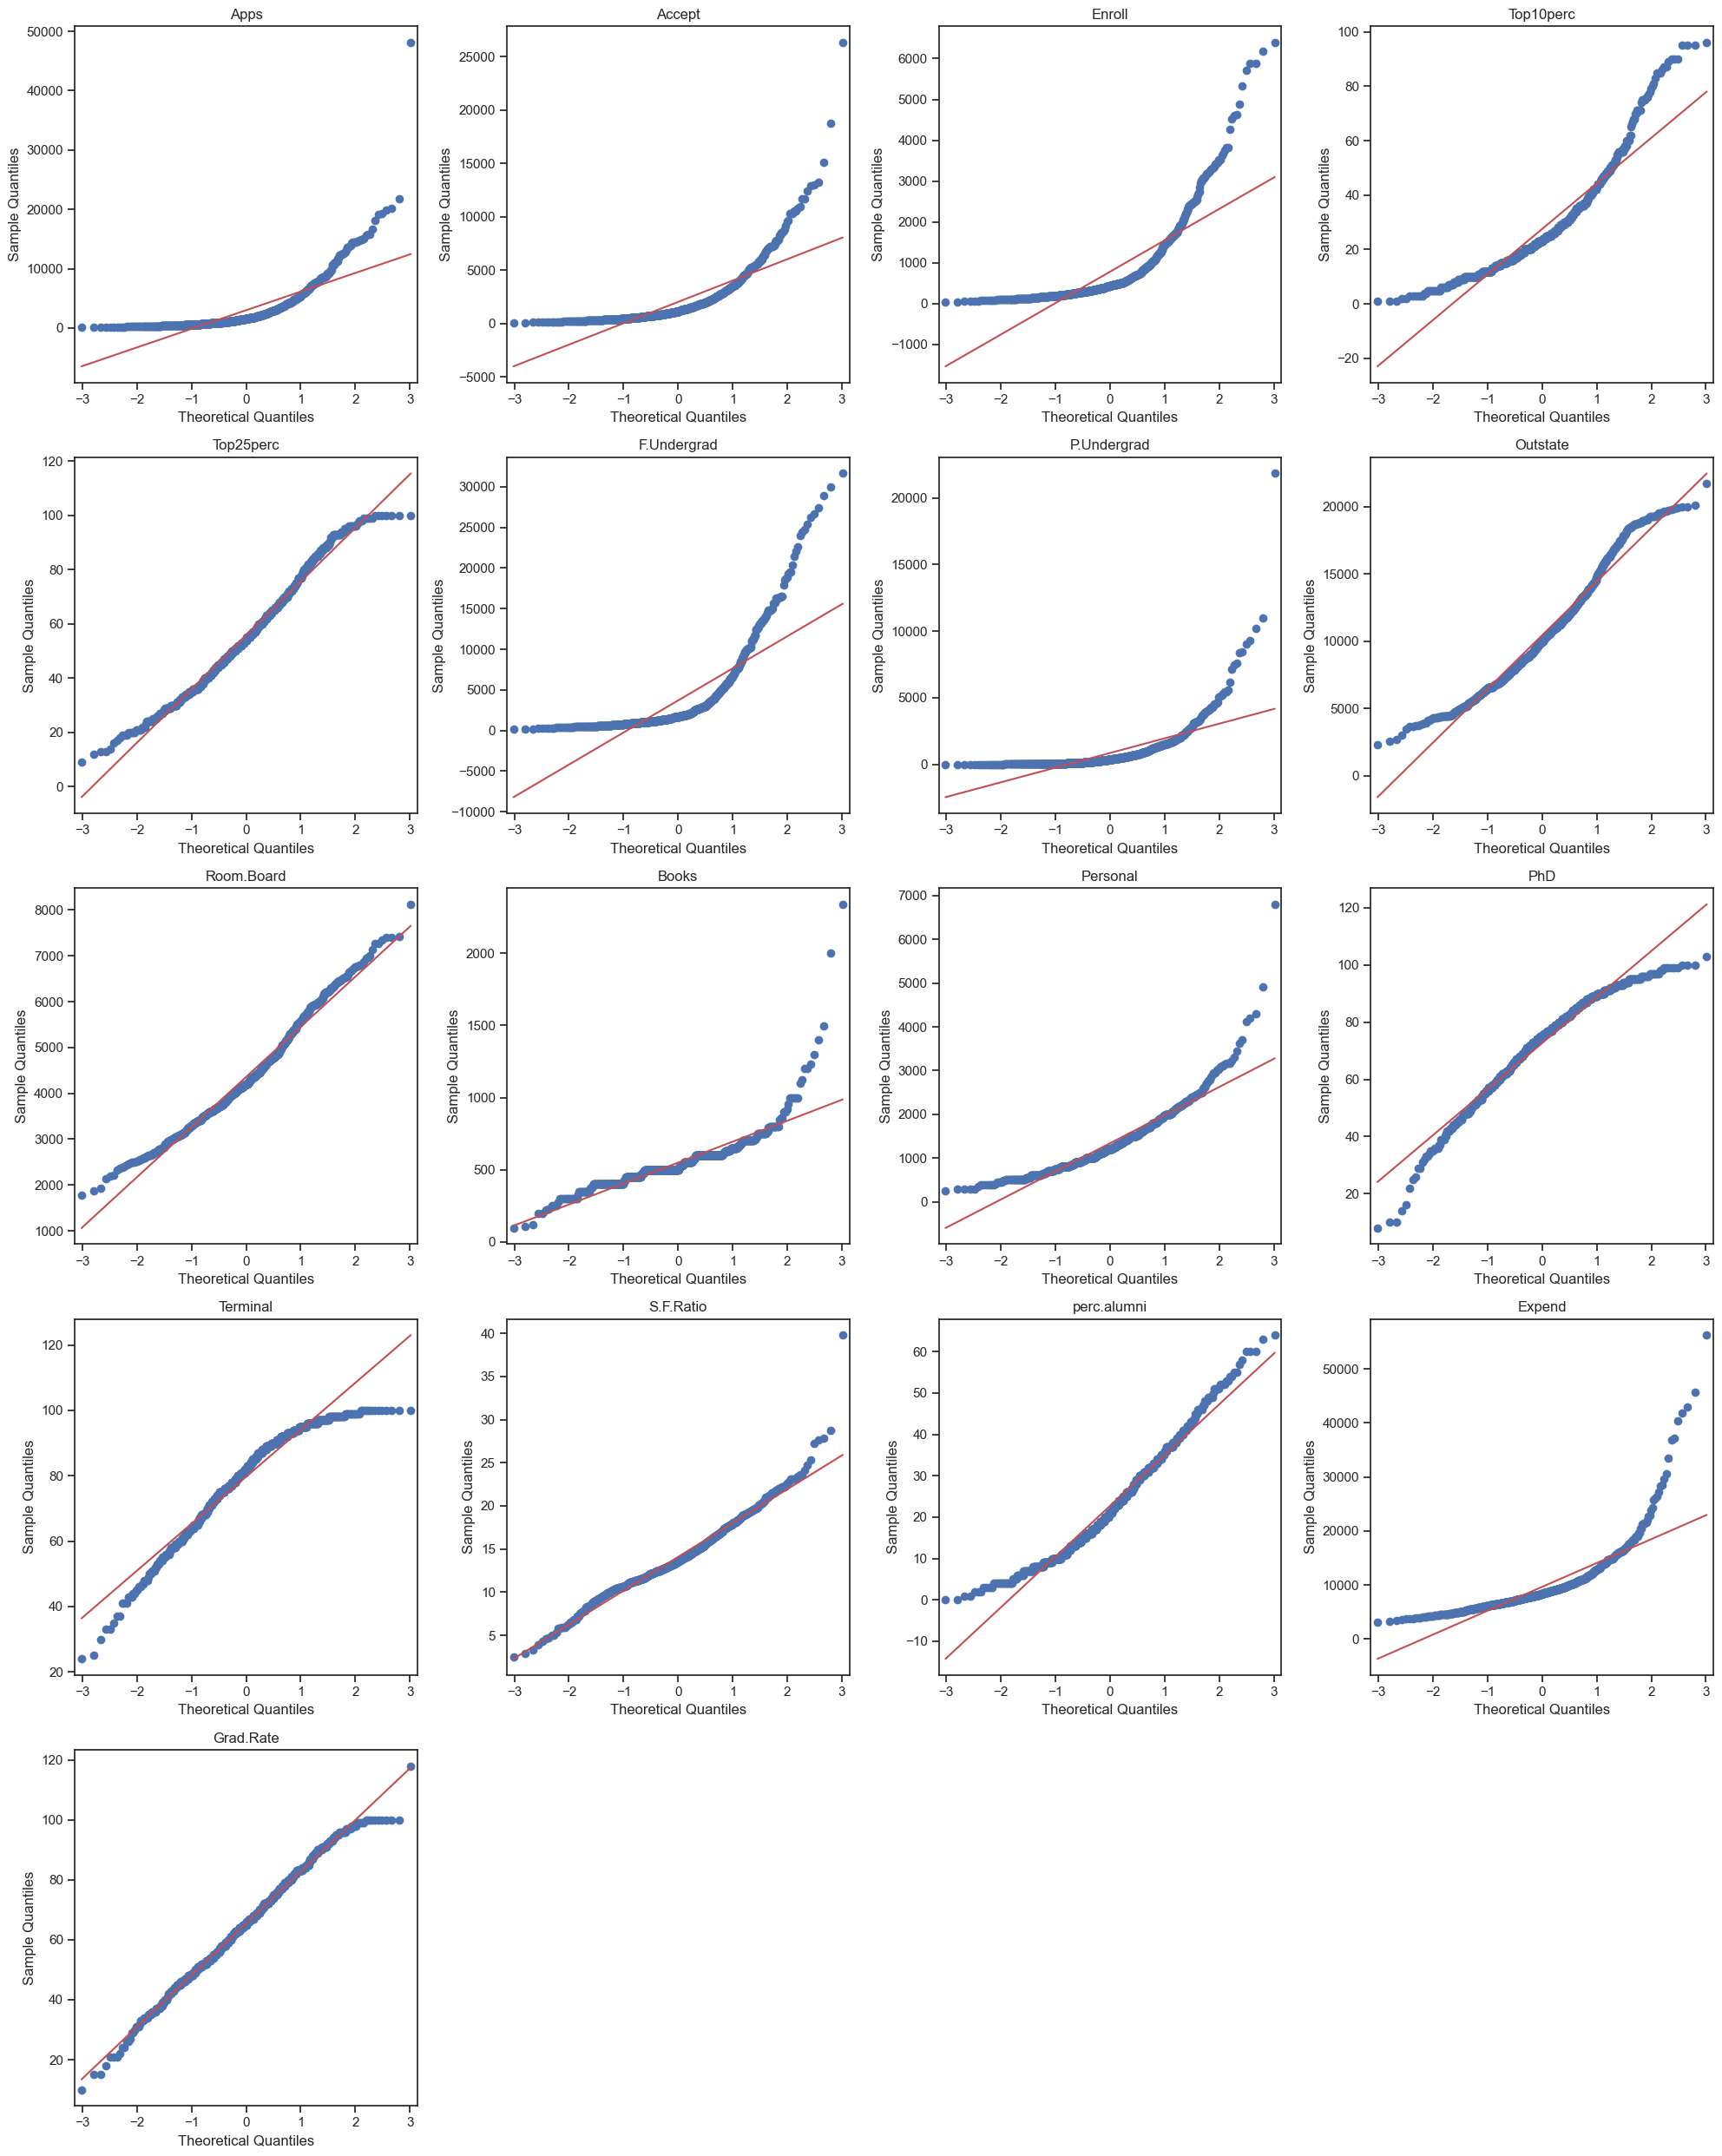

In [33]:
# Q-Q Plots for assessing normality

# Calculate the number of rows needed for the subplots
num_rows = int(np.ceil(len(num_col_list) / 4))

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the numerical columns and create Q-Q plots
for i, col in enumerate(num_col_list):
    sm.qqplot(edu_df[col], line='r', ax=axes[i])
    axes[i].set_title(col)

# Hide any empty subplots if the number of columns is not a multiple of 4
for i in range(len(num_col_list), num_rows * 4):
    axes[i].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [34]:
# Shapiro-Wilk test to assess normality

# Iterate through numerical columns and perform Shapiro-Wilk test
for col in num_col_list:
    statistic, p_value = shapiro(edu_df[col])
    print(f"Shapiro-Wilk test for {col}:")
    print(f"  Statistic: {statistic:.3f}")
    print(f"  P-value: {p_value:.3f}")
    print("-" * 20)  # Print a separator line

Shapiro-Wilk test for Apps:
  Statistic: 0.654
  P-value: 0.000
--------------------
Shapiro-Wilk test for Accept:
  Statistic: 0.664
  P-value: 0.000
--------------------
Shapiro-Wilk test for Enroll:
  Statistic: 0.678
  P-value: 0.000
--------------------
Shapiro-Wilk test for Top10perc:
  Statistic: 0.887
  P-value: 0.000
--------------------
Shapiro-Wilk test for Top25perc:
  Statistic: 0.984
  P-value: 0.000
--------------------
Shapiro-Wilk test for F.Undergrad:
  Statistic: 0.656
  P-value: 0.000
--------------------
Shapiro-Wilk test for P.Undergrad:
  Statistic: 0.523
  P-value: 0.000
--------------------
Shapiro-Wilk test for Outstate:
  Statistic: 0.968
  P-value: 0.000
--------------------
Shapiro-Wilk test for Room.Board:
  Statistic: 0.980
  P-value: 0.000
--------------------
Shapiro-Wilk test for Books:
  Statistic: 0.771
  P-value: 0.000
--------------------
Shapiro-Wilk test for Personal:
  Statistic: 0.893
  P-value: 0.000
--------------------
Shapiro-Wilk test for 

**Insights for the Individual Variables in based on the univariate analaysis**

**1. Apps (Number of applications received):**

* **Distribution:** Right-skewed, indicating a higher frequency of lower application numbers and a few institutions with very high application numbers.
* **Central Tendency:** Mean (3001) is higher than the median (1558), influenced by the right skew.
* **Dispersion:** High standard deviation (3870) reflects the wide range of application numbers.
* **Normality:** Q-Q plot shows deviation from normality, and Shapiro-Wilk test confirms significant non-normality (p < 0.05).
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** A few institutions receive a disproportionately large number of applications, while most receive a moderate number. Non-normality might require data transformations for some analyses.

**2. Accept (Number of applications accepted):**

* **Distribution:** Similar to 'Apps', right-skewed with a higher frequency of lower acceptance numbers.
* **Central Tendency:** Mean (2018) is higher than the median (1110), indicating the influence of the skew.
* **Dispersion:** High standard deviation (2451) reflects variability in acceptance numbers.
* **Normality:** Q-Q plot and Shapiro-Wilk test (p < 0.05) suggest non-normality.
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** Acceptance numbers follow a pattern similar to applications, with a few institutions accepting a large number and most accepting a moderate number. Non-normality should be considered for statistical methods.

**3. Enroll (Number of new students enrolled):**

* **Distribution:** Right-skewed, but less pronounced than 'Apps' and 'Accept'.
* **Central Tendency:** Mean (779) is higher than the median (434), indicating skewness.
* **Dispersion:** Standard deviation (929) reflects variability in enrollment numbers.
* **Normality:** Q-Q plot shows slight deviations, and Shapiro-Wilk test (p < 0.05) suggests non-normality.
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** Enrollment numbers follow the trend of applications and acceptances, but with less extreme skewness. Non-normality might need to be addressed for some analyses.

**4. Top10perc (Percentage of new students from top 10% of High School):**

* **Distribution:** Approximately symmetric, with a slight right skew.
* **Central Tendency:** Mean (27.5) is close to the median (23), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (17.7) reflects variability in percentages.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** The percentage of students from the top 10% varies across institutions, with a few outliers on both the high and low ends. Near-normality might be sufficient for many analyses.

**5. Top25perc (Percentage of new students from top 25% of High School):**

* **Distribution:** Similar to 'Top10perc', approximately symmetric with a slight right skew.
* **Central Tendency:** Mean (55.7) is close to the median (54), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (19.8) reflects variability in percentages.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** The percentage of students from the top 25% follows a pattern similar to 'Top10perc', with moderate variability and near-normality.

**6. F.Undergrad (Number of full-time undergraduate students):**

* **Distribution:** Right-skewed, indicating a higher frequency of lower full-time undergraduate enrollment.
* **Central Tendency:** Mean (3699) is higher than the median (1707), influenced by the skew.
* **Dispersion:** High standard deviation (4850) reflects a wide range of enrollment numbers.
* **Normality:** Q-Q plot shows deviation from normality, and Shapiro-Wilk test (p < 0.05) confirms significant non-normality.
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** A few institutions have a large number of full-time undergraduates, while most have a moderate number. Non-normality might require data transformations for certain analyses.

**7. P.Undergrad (Number of part-time undergraduate students):**

* **Distribution:** Right-skewed, similar to 'F.Undergrad' but with a higher frequency of lower enrollment.
* **Central Tendency:** Mean (855) is much higher than the median (309), indicating strong skewness.
* **Dispersion:** High standard deviation (1522) reflects variability in part-time enrollment.
* **Normality:** Q-Q plot shows deviation from normality, and Shapiro-Wilk test (p < 0.05) confirms non-normality.
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** Part-time undergraduate enrollment is typically low, but some institutions have a considerably larger number. Non-normality should be considered for statistical methods.

**8. Outstate (Number of students for whom the particular college is out of state):**

* **Distribution:** Approximately symmetric, with a slight right skew.
* **Central Tendency:** Mean (779) is close to the median (678), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (402) reflects variability in out-of-state student numbers.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** The number of out-of-state students varies across institutions, but the distribution is relatively symmetric with mild non-normality.

**9. Room.Board (Cost of Room and board):**

* **Distribution:** Approximately symmetric, with a slight right skew.
* **Central Tendency:** Mean (4357) is close to the median (4200), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (1096) reflects variability in room and board costs.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** Room and board costs vary, but the distribution is relatively symmetric and close to normal. Outliers represent institutions with particularly high or low costs.

**10. Books (Estimated book costs for a student):**

* **Distribution:** Approximately symmetric, with a slight right skew.
* **Central Tendency:** Mean (549) is close to the median (500), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (165) reflects variability in book costs.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** Book costs are generally moderate, with some variability and slight non-normality. Outliers might represent institutions with unusually high or low book expenses.

**11. Personal (Estimated personal spending for a student):**

* **Distribution:** Right-skewed, with a higher frequency of lower personal spending.
* **Central Tendency:** Mean (1340) is higher than the median (1200), indicating skewness.
* **Dispersion:** Moderate standard deviation (677) reflects variability in personal spending.
* **Normality:** Q-Q plot shows deviations from normality, and Shapiro-Wilk test (p < 0.05) confirms non-normality.
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** Personal spending varies across students, with a tendency towards lower spending and some outliers on the higher end. Non-normality should be considered for analyses.

**12. PhD (Percentage of faculties with Ph.D.’s):**

* **Distribution:** Approximately symmetric, with a slight left skew.
* **Central Tendency:** Mean (72.6) is close to the median (75), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (16.3) reflects variability in PhD percentages.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** The percentage of faculties with PhDs varies across institutions, but the distribution is relatively symmetric with mild non-normality.

**13. Terminal (Percentage of faculties with terminal degree):**

* **Distribution:** Similar to 'PhD', approximately symmetric with a slight left skew.
* **Central Tendency:** Mean (79.7) is close to the median (82), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (14.7) reflects variability in terminal degree percentages.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** The percentage of faculties with terminal degrees follows a pattern similar to 'PhD', with moderate variability and near-normality.

**14. S.F.Ratio (Student/faculty ratio):**

* **Distribution:** Approximately symmetric, with a slight right skew.
* **Central Tendency:** Mean (13.8) is close to the median (13.6), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (3.9) reflects variability in student-faculty ratios.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** Student-faculty ratios vary across institutions, but the distribution is relatively symmetric with mild non-normality.

**15. perc.alumni (Percentage of alumni who donate):**

* **Distribution:** Approximately symmetric, with a slight right skew.
* **Central Tendency:** Mean (22.7) is close to the median (21), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (12.6) reflects variability in alumni donation percentages.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** Alumni donation percentages vary, but the distribution is relatively symmetric with mild non-normality. Outliers might represent institutions with particularly high or low alumni engagement.

**16. Expend (The Instructional expenditure per student):**

* **Distribution:** Right-skewed, with a higher frequency of lower expenditure per student.
* **Central Tendency:** Mean (9660) is higher than the median (8377), indicating skewness.
* **Dispersion:** High standard deviation (5221) reflects variability in expenditure per student.
* **Normality:** Q-Q plot shows deviation from normality, and Shapiro-Wilk test (p < 0.05) confirms non-normality.
* **Outliers:** Boxplot shows potential outliers on the higher end.

**Insights:** Instructional expenditure per student varies widely, with some institutions spending considerably more. Non-normality might require data transformations for some analyses.

**17. Grad.Rate (Graduation rate):**

* **Distribution:** Approximately symmetric, with a slight left skew.
* **Central Tendency:** Mean (65.4) is close to the median (65), indicating near symmetry.
* **Dispersion:** Moderate standard deviation (17.1) reflects variability in graduation rates.
* **Normality:** Q-Q plot shows minor deviations, and Shapiro-Wilk test (p < 0.05) suggests slight non-normality.
* **Outliers:** Boxplot shows potential outliers on both ends.

**Insights:** Graduation rates are generally moderate, with some variability and slight non-normality. Outliers might represent institutions with unusually high or low graduation rates.

**Overall Insights from the Univariate Analysis**

1. **Data Distribution and Normality:**
   * Many variables, especially those related to the size and application/acceptance process of institutions (Apps, Accept, Enroll, F.Undergrad, P.Undergrad, Expend), exhibit **right-skewed distributions**. This suggests that most institutions have moderate values for these variables, while a few institutions are significantly larger or have much higher application/acceptance rates.
   * Most variables show at least slight deviations from normality, as indicated by the Shapiro-Wilk tests. This highlights the importance of considering the normality assumption when applying certain statistical methods. **Transformations may be necessary to normalize certain variables** for more robust analysis.
   * Variables like Top10perc, Top25perc, Outstate, Room.Board, Books, PhD, Terminal, S.F.Ratio, perc.alumni, and Grad.Rate show relatively more symmetric distributions or mild deviations from normality compared to the variables mentioned above.

2. **Potential Outliers:**
   * Potential outliers are present in many of the variables, as indicated by boxplots. These outliers represent institutions with unusually high or low values for specific features.
   * The presence of outliers warrants further investigation to understand their nature and potential impact on analysis. **Decisions regarding outlier handling** (e.g., removal or transformation) should be made carefully based on the context and specific analytical goals.

3. **Relationships between Variables:**
   * **Strong positive correlations** exist between variables related to the application and enrollment process (Apps, Accept, Enroll). This is intuitive, as higher application numbers generally lead to higher acceptance and enrollment numbers.
   * Positive correlations are also observed between variables like Top10perc and Top25perc (student quality), Outstate and Room.Board (cost factors), and Expend and Grad.Rate (institutional resources and outcomes).
   * These correlations provide valuable insights into the relationships between different aspects of higher education institutions and their performance.

4. **Data Scaling:**
   * The range and scale of different variables vary significantly. For instance, 'Apps' has a much larger range and scale than 'S.F.Ratio'.
   * **Data scaling, such as standardization, would be necessary** for analyses like PCA, where variables with different scales can disproportionately influence results. Scaling ensures that all variables contribute equally to the analysis.

**Overall Interpretation:**

* The data reveals a diverse landscape of institutions with varying characteristics, including size, student demographics, faculty qualifications, costs, and outcomes.
* The presence of non-normality and outliers highlights the importance of careful data preprocessing and consideration of appropriate statistical methods.
* Strong correlations between specific variables provide valuable insights into the relationships that influence institutional performance and decision-making in higher education.
* **PCA could be a valuable technique** to further explore the underlying patterns and structure in the data. The insights derived from PCA can help identify important dimensions that differentiate institutions and potentially guide strategic planning in the higher education context.

In [35]:
# Outlier analysis
outlier_edu = detect_outliers_iqr(edu_df, num_col_list)
outlier_edu

% Upper Outlier  % Lower Outlier  % Total Outlier
F.Undergrad            12.48             0.00            12.48
Enroll                 10.17             0.00            10.17
Accept                  9.40             0.00             9.40
Apps                    9.01             0.00             9.01
P.Undergrad             8.62             0.00             8.62
Expend                  6.18             0.00             6.18
Books                   4.63             1.29             5.92
Top10perc               5.02             0.00             5.02
Personal                2.57             0.00             2.57
S.F.Ratio               1.03             0.51             1.54
Terminal                0.00             1.03             1.03
PhD                     0.00             1.03             1.03
Room.Board              0.90             0.00             0.90
perc.alumni             0.64             0.00             0.64
Grad.Rate               0.13             0.39             0.52
Outstate                0.13             0.00             0.13
Top25perc               0.00             0.00             0.00

**Insights from Outlier analysis**

1. **High Outlier Percentage Features:**
   - `Apps`, `Accept`, `Enroll`, `F.Undergrad`, `P.Undergrad`, `Outstate`, `Room.Board`, `Personal`, `Expend`: These features have the highest total percentage of outliers, ranging from around 6% to 13%. This indicates that there are a considerable number of institutions with extreme values for these characteristics compared to the majority.

2. **Moderate Outlier Percentage Features:**
   - `Top10perc`, `Top25perc`, `Books`, `PhD`, `Terminal`, `S.F.Ratio`, `perc.alumni`, `Grad.Rate`: These features have a moderate percentage of outliers, ranging from around 1% to 6%. While outliers are still present, they are less prevalent compared to the high outlier percentage features.

3. **Nature of Outliers:**
   - Most of the outliers in the high percentage features are likely **upper outliers**, meaning they represent institutions with unusually high values for those features. For example, some institutions may have a much larger number of applications, enrollments, or expenditures compared to the average.
   - The moderate percentage features tend to have a mix of upper and lower outliers, indicating institutions with extreme values on both ends of the spectrum.

4. **Potential Impact on Analysis:**
   - Outliers can significantly influence statistical analyses and model performance. They can skew distributions, distort correlation coefficients, and affect the accuracy of predictions.
   - It's crucial to consider the presence of outliers and potentially handle them using appropriate techniques like transformation or removal, depending on the specific analysis being conducted.

5. **Business Implications:**
   - The presence of outliers highlights the diversity of higher education institutions in terms of factors like size, selectivity, student demographics, costs, and outcomes.
   - Understanding the nature and distribution of outliers can help identify institutions that are significantly different from the norm and may require further investigation or specific strategies for engagement.

**Overall Interpretation:**

The outlier analysis reveals that the `edu_df` dataset contains a significant number of outliers, particularly for features related to size, application process, and expenditures. These outliers represent institutions with extreme characteristics compared to the majority. This information is crucial for data preprocessing, analysis, and interpretation, as outliers can have a substantial impact on results and should be handled carefully. The presence of outliers also emphasizes the diversity of institutions in the dataset and provides valuable insights into the higher education landscape.

#### **3b. Bivariate Analysis**

For the bivariate analysis we will be using correlation and covariation matrices. Moreover, we will use heatmaps to visualize correlation and pairplots to visualize the relation between each numerical variable.

**Correlation Matrix vs. Covariance Matrix**

**Correlation Matrix**

* **Definition:** A correlation matrix is a table showing the correlation coefficients between variables. Each cell in the table shows the correlation between two variables.
* **Values:** Correlation coefficients range from -1 to +1.
    * -1 indicates a perfect negative linear correlation.
    * +1 indicates a perfect positive linear correlation.
    * 0 indicates no linear correlation.
* **Standardized:** Correlation coefficients are standardized, meaning they are dimensionless and not affected by the scale of the variables.
* **Interpretation:** Correlation matrices are easy to interpret because the values are standardized and have a clear meaning. They provide a quick overview of the relationships between variables in a dataset.

**Covariance Matrix**

* **Definition:** A covariance matrix is a table showing the covariances between variables. Each cell in the table shows the covariance between two variables.
* **Values:** Covariance values can range from negative infinity to positive infinity.
    * A positive covariance indicates that the variables tend to move in the same direction.
    * A negative covariance indicates that the variables tend to move in opposite directions.
    * A covariance of 0 indicates that there is no linear relationship between the variables.
* **Not Standardized:** Covariance values are not standardized, meaning they are affected by the scale of the variables.
* **Interpretation:** Covariance matrices can be more difficult to interpret than correlation matrices because the values are not standardized. However, they provide information about the direction and magnitude of the linear relationship between variables.

**Key Differences:**

| Feature | Correlation Matrix | Covariance Matrix |
|---|---|---|
| **Values** | Correlation coefficients (-1 to +1) | Covariance values (-∞ to +∞) |
| **Standardization** | Standardized (dimensionless) | Not standardized (affected by scale) |
| **Interpretation** | Easier to interpret due to standardized values | More difficult to interpret due to unstandardized values |
| **Focus** | Strength and direction of linear relationship | Direction and magnitude of linear relationship |

**In Summary:**

* **Correlation matrices are used to understand the strength and direction of the linear relationship between variables.** They are easy to interpret because the values are standardized.
* **Covariance matrices are used to understand the direction and magnitude of the linear relationship between variables.** They are less intuitive to interpret because the values are not standardized.

In [36]:
cov_df = edu_df[num_col_list].cov()
cov_df

Apps        Accept        Enroll     Top10perc  \
Apps         1.497846e+07  8.949860e+06  3.045256e+06  23132.773138   
Accept       8.949860e+06  6.007960e+06  2.076268e+06   8321.124872   
Enroll       3.045256e+06  2.076268e+06  8.633684e+05   2971.583415   
Top10perc    2.313277e+04  8.321125e+03  2.971583e+03    311.182456   
Top25perc    2.695266e+04  1.201340e+04  4.172592e+03    311.630480   
F.Undergrad  1.528970e+07  1.039358e+07  4.347530e+06  12089.113681   
P.Undergrad  2.346620e+06  1.646670e+06  7.257907e+05  -2829.474981   
Outstate     7.809704e+05 -2.539623e+05 -5.811885e+05  39907.179832   
Room.Board   7.000729e+05  2.443471e+05 -4.099706e+04   7186.705605   
Books        8.470375e+04  4.594281e+04  1.729120e+04    346.177405   
Personal     4.683468e+05  3.335566e+05  1.767380e+05  -1114.551186   
PhD          2.468943e+04  1.423820e+04  5.028961e+03    153.184870   
Terminal     2.105307e+04  1.218209e+04  4.217086e+03    127.551581   
S.F.Ratio    1.465061e+03  1.709838e+03  8.726848e+02    -26.874525   
perc.alumni -4.327122e+03 -4.859487e+03 -2.081694e+03     99.567208   
Expend       5.246171e+06  1.596272e+06  3.113454e+05  60879.310196   
Grad.Rate    9.756422e+03  2.834163e+03 -3.565880e+02    149.992164   

                Top25perc   F.Undergrad   P.Undergrad      Outstate  \
Apps         26952.663479  1.528970e+07  2.346620e+06  7.809704e+05   
Accept       12013.404757  1.039358e+07  1.646670e+06 -2.539623e+05   
Enroll        4172.592435  4.347530e+06  7.257907e+05 -5.811885e+05   
Top10perc      311.630480  1.208911e+04 -2.829475e+03  3.990718e+04   
Top25perc      392.229216  1.915895e+04 -1.615412e+03  3.899243e+04   
F.Undergrad  19158.952782  2.352658e+07  4.212910e+06 -4.209843e+06   
P.Undergrad  -1615.412144  4.212910e+06  2.317799e+06 -1.552704e+06   
Outstate     38992.427500 -4.209843e+06 -1.552704e+06  1.618466e+07   
Room.Board    7199.903568 -3.664582e+05 -1.023919e+05  2.886597e+06   
Books          377.759266  9.253576e+04  2.041045e+04  2.580824e+04   
Personal     -1083.605065  1.041709e+06  3.297324e+05 -8.146737e+05   
PhD            176.518449  2.521178e+04  3.706756e+03  2.515752e+04   
Terminal       153.002612  2.142424e+04  3.180597e+03  2.416415e+04   
S.F.Ratio      -23.097199  5.370209e+03  1.401303e+03 -8.835254e+03   
perc.alumni    102.550946 -1.379193e+04 -5.297337e+03  2.822955e+04   
Expend       54546.483305  4.724040e+05 -6.643512e+05  1.413324e+07   
Grad.Rate      162.371398 -6.563308e+03 -6.721062e+03  3.947968e+04   

               Room.Board         Books      Personal           PhD  \
Apps         7.000729e+05  84703.752639  4.683468e+05  24689.433666   
Accept       2.443471e+05  45942.807867  3.335566e+05  14238.201489   
Enroll      -4.099706e+04  17291.199742  1.767380e+05   5028.961166   
Top10perc    7.186706e+03    346.177405 -1.114551e+03    153.184870   
Top25perc    7.199904e+03    377.759266 -1.083605e+03    176.518449   
F.Undergrad -3.664582e+05  92535.764728  1.041709e+06  25211.784197   
P.Undergrad -1.023919e+05  20410.446674  3.297324e+05   3706.756219   
Outstate     2.886597e+06  25808.242145 -8.146737e+05  25157.515051   
Room.Board   1.202743e+06  23170.313390 -1.480838e+05   5895.034749   
Books        2.317031e+04  27259.779946  2.004303e+04     72.534242   
Personal    -1.480838e+05  20043.025650  4.584258e+05   -120.898783   
PhD          5.895035e+03     72.534242 -1.208988e+02    266.608636   
Terminal     6.047300e+03    242.963918 -3.051542e+02    204.231332   
S.F.Ratio   -1.574206e+03    -20.867207  3.654158e+02     -8.436492   
perc.alumni  3.701431e+03    -82.263132 -2.399311e+03     50.383230   
Expend       2.873308e+06  96912.580326 -3.460978e+05  36898.058233   
Grad.Rate    8.005360e+03      3.008837 -3.132615e+03     85.557109   

                 Terminal     S.F.Ratio   perc.alumni        Expend  \
Apps         21053.067602   1465.060576  -4327.122381  5.246171e+06   
Accept       12182.093828   1709.838189  -

In [37]:
# Generate a correlation matrix
corr_df = edu_df[num_col_list].corr(method='pearson')
corr_df

Apps    Accept    Enroll  Top10perc  Top25perc  F.Undergrad  \
Apps         1.000000  0.943451  0.846822   0.338834   0.351640     0.814491   
Accept       0.943451  1.000000  0.911637   0.192447   0.247476     0.874223   
Enroll       0.846822  0.911637  1.000000   0.181294   0.226745     0.964640   
Top10perc    0.338834  0.192447  0.181294   1.000000   0.891995     0.141289   
Top25perc    0.351640  0.247476  0.226745   0.891995   1.000000     0.199445   
F.Undergrad  0.814491  0.874223  0.964640   0.141289   0.199445     1.000000   
P.Undergrad  0.398264  0.441271  0.513069  -0.105356  -0.053577     0.570512   
Outstate     0.050159 -0.025755 -0.155477   0.562331   0.489394    -0.215742   
Room.Board   0.164939  0.090899 -0.040232   0.371480   0.331490    -0.068890   
Books        0.132559  0.113525  0.112711   0.118858   0.115527     0.115550   
Personal     0.178731  0.200989  0.280929  -0.093316  -0.080810     0.317200   
PhD          0.390697  0.355758  0.331469   0.531828   0.545862     0.318337   
Terminal     0.369491  0.337583  0.308274   0.491135   0.524749     0.300019   
S.F.Ratio    0.095633  0.176229  0.237271  -0.384875  -0.294629     0.279703   
perc.alumni -0.090226 -0.159990 -0.180794   0.455485   0.417864    -0.229462   
Expend       0.259592  0.124717  0.064169   0.660913   0.527447     0.018652   
Grad.Rate    0.146755  0.067313 -0.022341   0.494989   0.477281    -0.078773   

             P.Undergrad  Outstate  Room.Board     Books  Personal       PhD  \
Apps            0.398264  0.050159    0.164939  0.132559  0.178731  0.390697   
Accept          0.441271 -0.025755    0.090899  0.113525  0.200989  0.355758   
Enroll          0.513069 -0.155477   -0.040232  0.112711  0.280929  0.331469   
Top10perc      -0.105356  0.562331    0.371480  0.118858 -0.093316  0.531828   
Top25perc      -0.053577  0.489394    0.331490  0.115527 -0.080810  0.545862   
F.Undergrad     0.570512 -0.215742   -0.068890  0.115550  0.317200  0.318337   
P.Undergrad     1.000000 -0.253512   -0.061326  0.081200  0.319882  0.149114   
Outstate       -0.253512  1.000000    0.654256  0.038855 -0.299087  0.382982   
Room.Board     -0.061326  0.654256    1.000000  0.127963 -0.199428  0.329202   
Books           0.081200  0.038855    0.127963  1.000000  0.179295  0.026906   
Personal        0.319882 -0.299087   -0.199428  0.179295  1.000000 -0.010936   
PhD             0.149114  0.382982    0.329202  0.026906 -0.010936  1.000000   
Terminal        0.141904  0.407983    0.374540  0.099955 -0.030613  0.849587   
S.F.Ratio       0.232531 -0.554821   -0.362628 -0.031929  0.136345 -0.130530   
perc.alumni    -0.280792  0.566262    0.272363 -0.040208 -0.285968  0.249009   
Expend         -0.083568  0.672779    0.501739  0.112409 -0.097892  0.432762   
Grad.Rate      -0.257001  0.571290    0.424942  0.001061 -0.269344  0.305038   

             Terminal  S.F.Ratio  perc.alumni    Expend  Grad.Rate  
Apps         0.369491   0.095633    -0.090226  0.259592   0.146755  
Accept       0.337583   0.176229    -0.159990  0.124717   0.067313  
Enroll       0.308274   0.237271    -0.180794  0.064169  -0.022341  
Top10perc    0.491135  -0.384875     0.455485  0.660913   0.494989  
Top25perc    0.524749  -0.294629     0.417864  0.527447   0.477281  
F.Undergrad  0.300019   0.279703    -0.229462  0.018652  -0.078773  
P.Undergrad  0.141904   0.232531    -0.280792 -0.083568  -0.257001  
Outstate     0.407983  -0.554821     0.566262  0.672779   0.571290  
Room.Board   0.374540  -0.362628     0.272363  0.501739   0.424942  
Books        0.099955  -0.031929    -0.040208  0.112409   0.001061  
Personal    -0.030613   0.136345    -0.285968 -0.097892  -0.269344  
PhD          0.849587  -0.130530     0.249009  0.432762   0.305038  
Terminal     1.000000  -0.160104     0.267130  0.438799   0.289527  
S.F.Ratio   -0.160104   1.000000    -0.402929 -0.583832  -0.306710  
perc.alumni  0.267130  -0.402929     1.000000  0.417712   0.490898  
Expend       0.438799  -0.58383

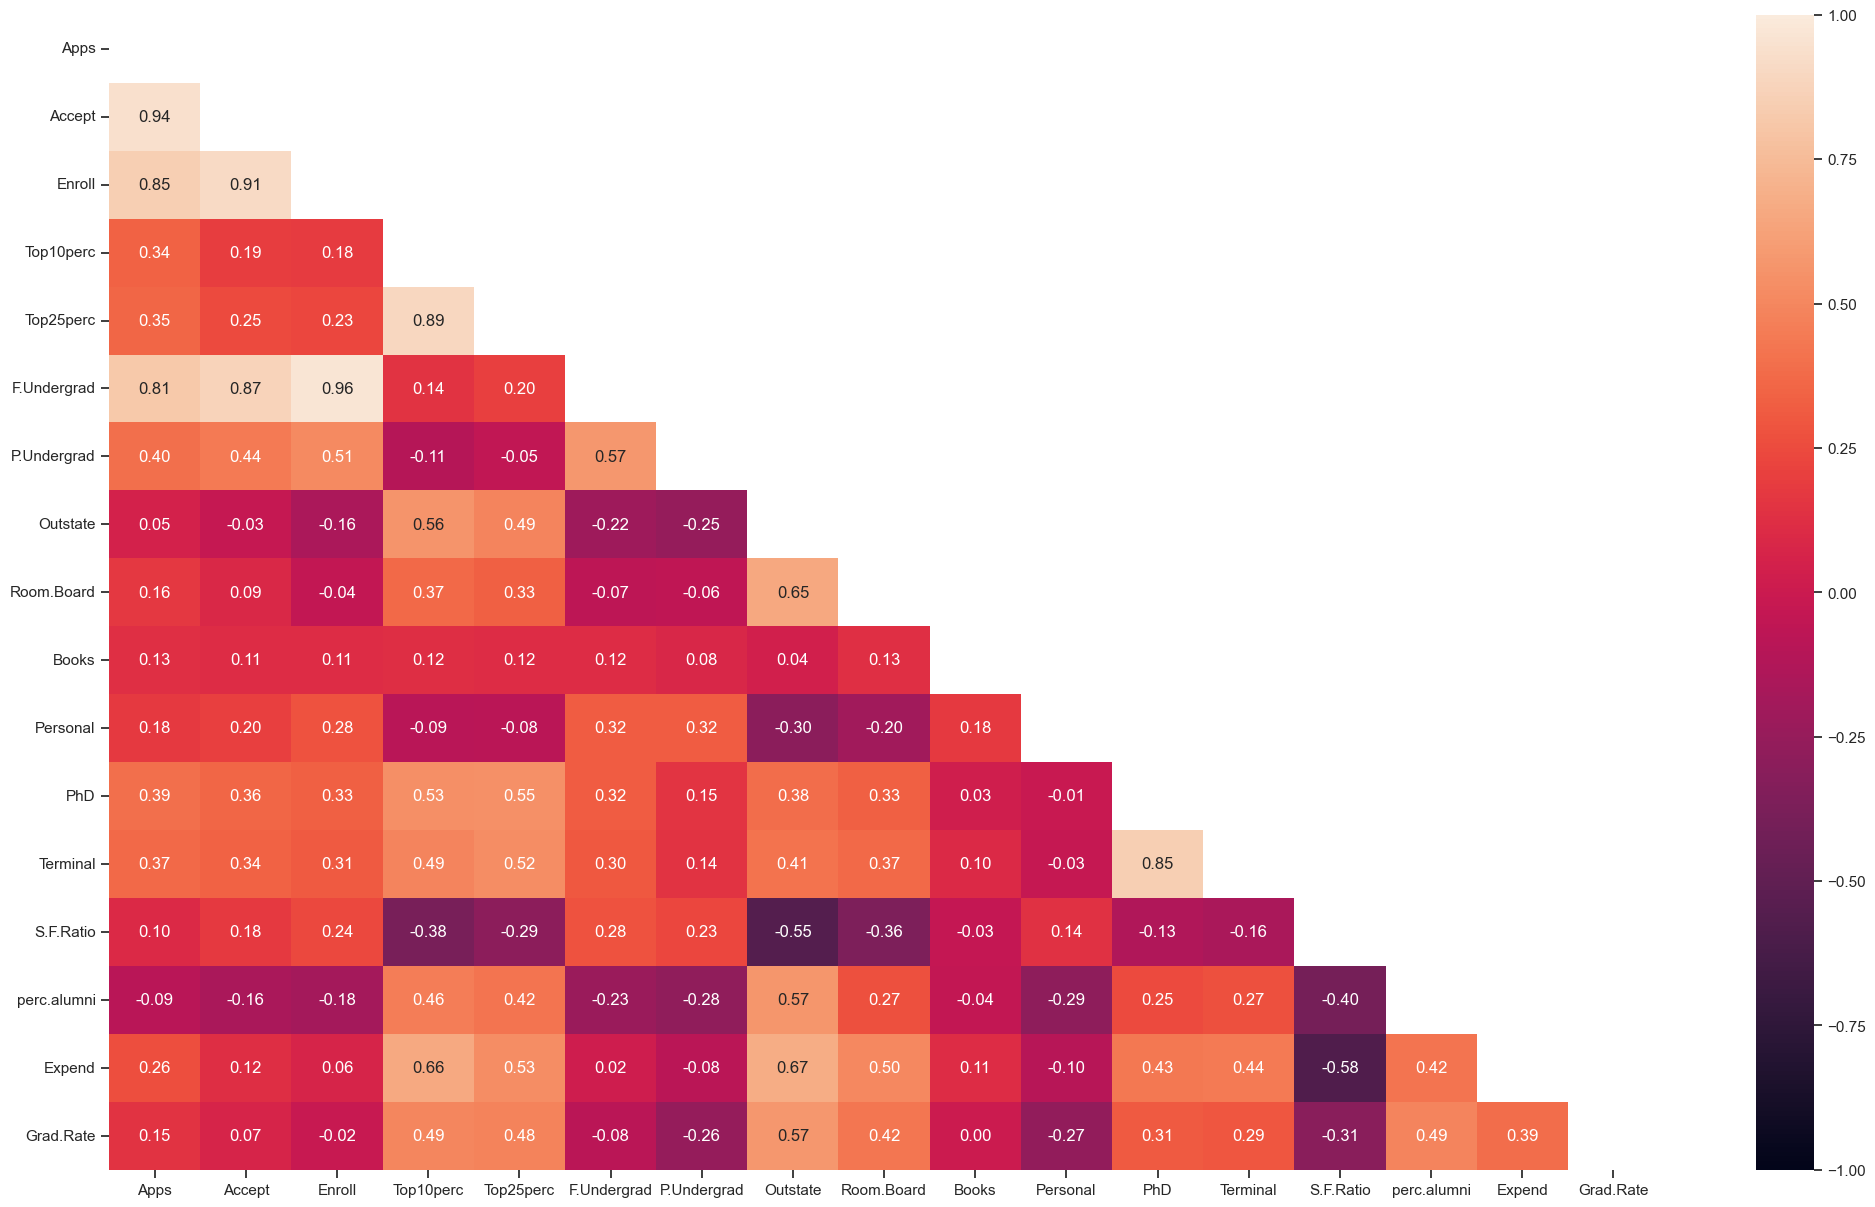

In [39]:
# Generate correlation heatmap
mask = np.triu(np.ones_like(corr_df, dtype=bool))
plt.figure(figsize=(25, 15))
sns.heatmap(corr_df, annot=True, fmt='.2f', vmin=-1, vmax=1, mask=mask, cbar='b' )
plt.show()

<Figure size 3000x5000 with 0 Axes>

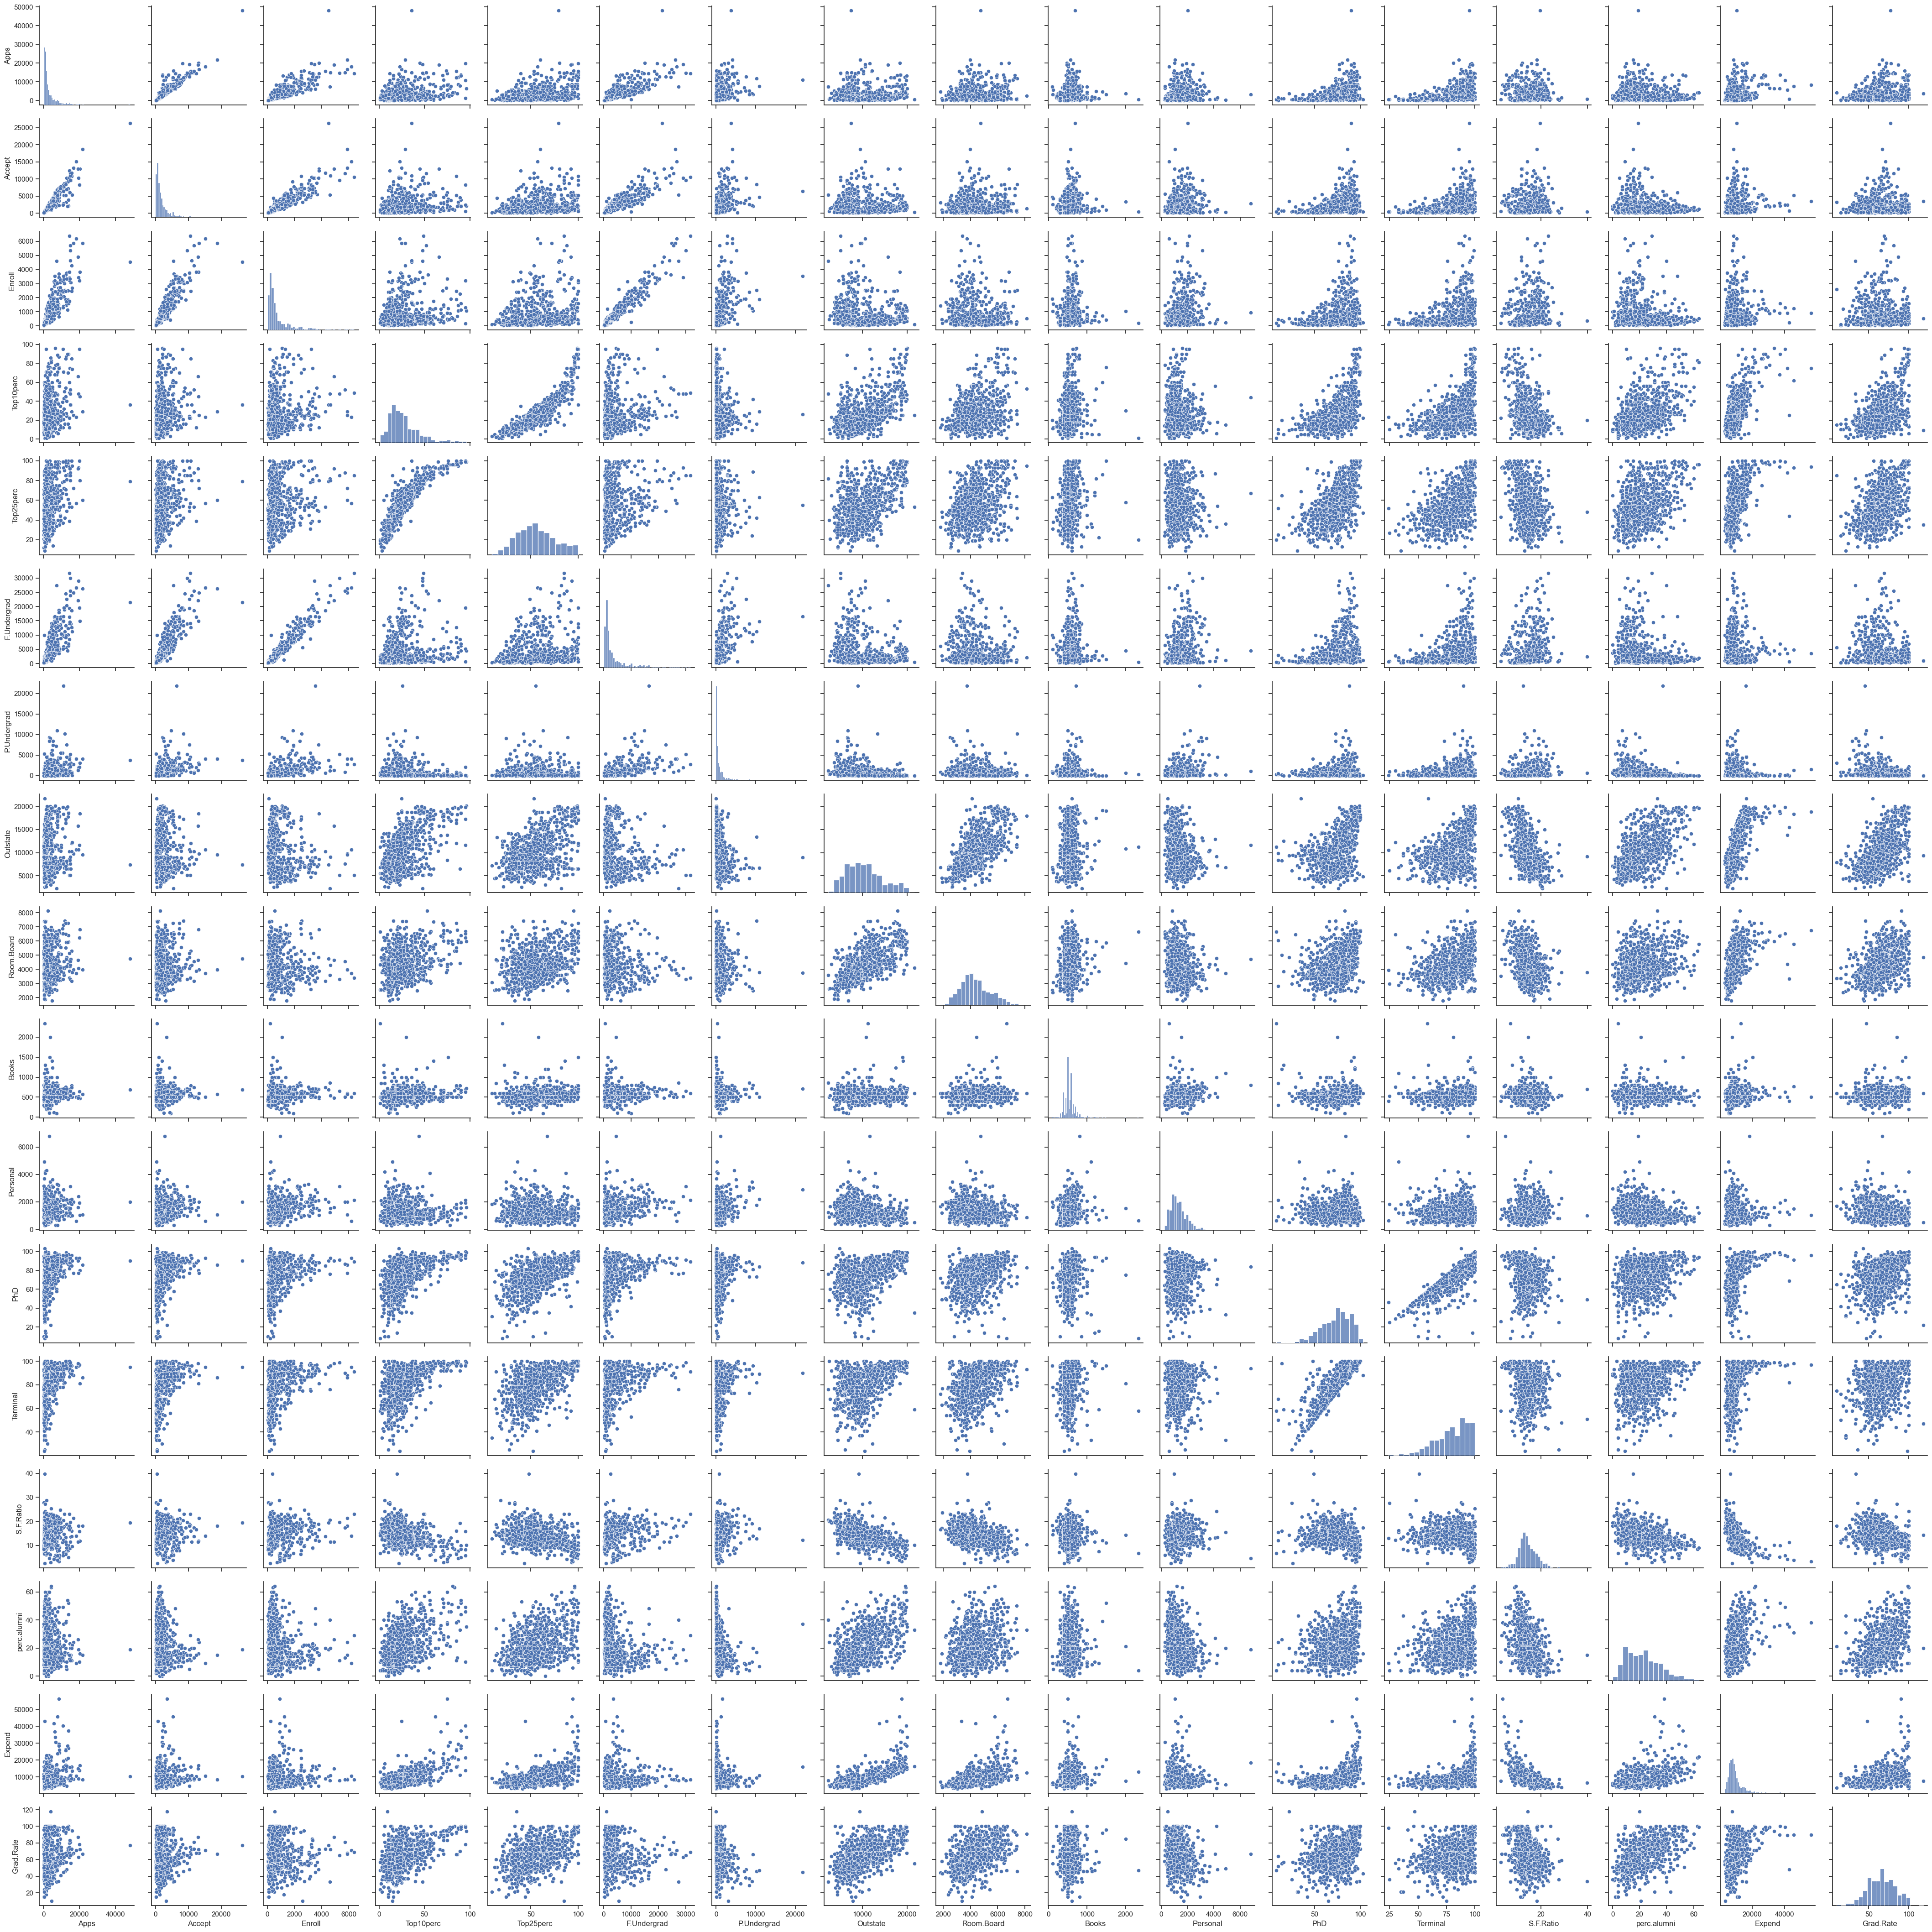

In [40]:
# Pair plot
plt.figure(figsize=(30,50))
sns.pairplot(data=edu_df[num_col_list], palette='Set1');
plt.tight_layout()
plt.show()

**Insights from the Bivariate analysis**

**Correlation Heatmap:**

1. **Strong Positive Correlations:**
   - `Apps`, `Accept`, `Enroll`: These variables have a strong positive correlation, indicating that institutions with higher application numbers tend to have higher acceptance and enrollment numbers.
   - `Top10perc`, `Top25perc`: These variables are also strongly positively correlated, suggesting that institutions attracting students from the top 10% of their high school class also attract students from the top 25%.
   - `F.Undergrad`, `P.Undergrad`: These variables have a moderate positive correlation, meaning that institutions with more full-time undergraduate students tend to have more part-time undergraduate students as well.
   - `Outstate`, `Room.Board`: There is a moderate positive correlation between out-of-state tuition and room and board costs, suggesting that institutions with higher out-of-state tuition also tend to have higher room and board costs.
   - `Expend`, `Grad.Rate`: A moderate positive correlation exists between instructional expenditure per student and graduation rate, indicating that institutions with higher spending per student tend to have higher graduation rates.

2. **Negative Correlations:**
   - `S.F.Ratio`, `Grad.Rate`: There is a weak negative correlation between the student-faculty ratio and graduation rate, suggesting that institutions with lower student-faculty ratios (more faculty per student) tend to have slightly higher graduation rates.
   - `perc.alumni`, `Grad.Rate`: A weak negative correlation is observed between the percentage of alumni who donate and the graduation rate, which might indicate that institutions with higher graduation rates might not necessarily have higher alumni donation percentages.

**Pair Plot:**

1. **Linear Relationships:** The pair plot visually confirms the strong positive linear relationships between `Apps`, `Accept`, and `Enroll`, as well as between `Top10perc` and `Top25perc`. It also shows the moderate positive linear relationships between `Outstate` and `Room.Board`, and between `Expend` and `Grad.Rate`.

2. **Non-linear Relationships:** Some variables exhibit non-linear relationships, such as the relationship between `S.F.Ratio` and `Grad.Rate`, which appears to have a slight curve.

3. **Clustering:** The pair plot can also help identify potential clusters of institutions based on their characteristics. For example, there might be a cluster of institutions with high application numbers, high acceptance rates, and high enrollment numbers.

**Overall Interpretation:**

The correlation heatmap and pair plot provide valuable insights into the relationships between different features in the `edu_df` dataset. They reveal strong positive correlations between variables related to the application and enrollment process, student quality, costs, and institutional resources and outcomes. They also highlight some negative correlations and potential non-linear relationships. These insights can help in understanding the factors that influence institutional performance and in identifying potential clusters of institutions with similar characteristics.

### **4. PCA and other analyses**

Alright! Now that we have garnered suffcient insights into the data, it's time for PCA and other analyses. However, before moving to PCA, the data needs to be scaled as the values in different columns are of different scale which will impact the results. For this purpose, there are 2 scaling methods available for us namely, z-scaler and standard scaler. Following are the differences between them and when to use them.

**Z-score vs. StandardScaler**

* **Z-score (using `scipy.stats.zscore`)**

    * **Functionality:** `zscore` is a function from the `scipy.stats` module that calculates the z-score for each data point in an array or Series.
    * **Formula:** It uses the formula: `z = (x - mean) / std`, where `x` is the data point, `mean` is the mean of the data, and `std` is the standard deviation of the data.
    * **Output:** It returns an array or Series containing the z-scores.
    * **Application:** `zscore` is often used for data normalization, especially when dealing with individual data points or features. It centers the data around zero and scales it by the standard deviation.

* **StandardScaler (from `sklearn.preprocessing`)**

    * **Functionality:** `StandardScaler` is a class from the `sklearn.preprocessing` module that transforms data to have zero mean and unit variance.
    * **Formula:** Similar to `zscore`, it also uses the formula: `z = (x - mean) / std`, but it works with entire datasets (DataFrames or arrays).
    * **Output:** It transforms the input data and returns a new array or DataFrame with the transformed data.
    * **Application:** `StandardScaler` is commonly used in machine learning pipelines for feature scaling. It is more flexible than `zscore` as it can be fit to a training dataset and then used to transform both training and testing datasets consistently.

**Key Differences:**

1. **Scope:** `zscore` works on individual data points or features, while `StandardScaler` works on entire datasets.
2. **Flexibility:** `StandardScaler` is more flexible for machine learning pipelines because it can be fit to a training dataset and then used consistently for other datasets.
3. **Object-oriented:** `StandardScaler` is an object-oriented class, allowing for fitting and transforming data separately, while `zscore` is a function that directly calculates z-scores.

**Summary:**

* If we need to **normalize individual data points or features, use `zscore`**.
* If we need to **scale features in a machine learning pipeline, use `StandardScaler`**.

For the present study, let us use `StandardScaler` as it is most robust.

In [41]:
# Drop the 'Names' column
num_edu_df = edu_df.drop(columns=['Names'])

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the numerical data and transform it
scaled_data = scaler.fit_transform(num_edu_df)

# Create a new DataFrame with the scaled data
scaled_edu_df = pd.DataFrame(scaled_data, columns=num_edu_df.columns, index=num_edu_df.index)

# Display the first few rows of the scaled DataFrame
scaled_edu_df.head()

Apps    Accept    Enroll  Top10perc  Top25perc  F.Undergrad  \
0 -0.346882 -0.321205 -0.063509  -0.258583  -0.191827    -0.168116   
1 -0.210884 -0.038703 -0.288584  -0.655656  -1.353911    -0.209788   
2 -0.406866 -0.376318 -0.478121  -0.315307  -0.292878    -0.549565   
3 -0.668261 -0.681682 -0.692427   1.840231   1.677612    -0.658079   
4 -0.726176 -0.764555 -0.780735  -0.655656  -0.596031    -0.711924   

   P.Undergrad  Outstate  Room.Board     Books  Personal       PhD  Terminal  \
0    -0.209207 -0.746356   -0.964905 -0.602312  1.270045 -0.163028 -0.115729   
1     0.244307  0.457496    1.909208  1.215880  0.235515 -2.675646 -3.378176   
2    -0.497090  0.201305   -0.554317 -0.905344 -0.259582 -1.204845 -0.931341   
3    -0.520752  0.626633    0.996791 -0.602312 -0.688173  1.185206  1.175657   
4     0.009005 -0.716508   -0.216723  1.518912  0.235515  0.204672 -0.523535   

   S.F.Ratio  perc.alumni    Expend  Grad.Rate  
0   1.013776    -0.867574 -0.501910  -0.318252  
1  -0.477704    -0.544572  0.166110  -0.551262  
2  -0.300749     0.585935 -0.177290  -0.667767  
3  -1.615274     1.151188  1.792851  -0.376504  
4  -0.553542    -1.675079  0.241803  -2.939613

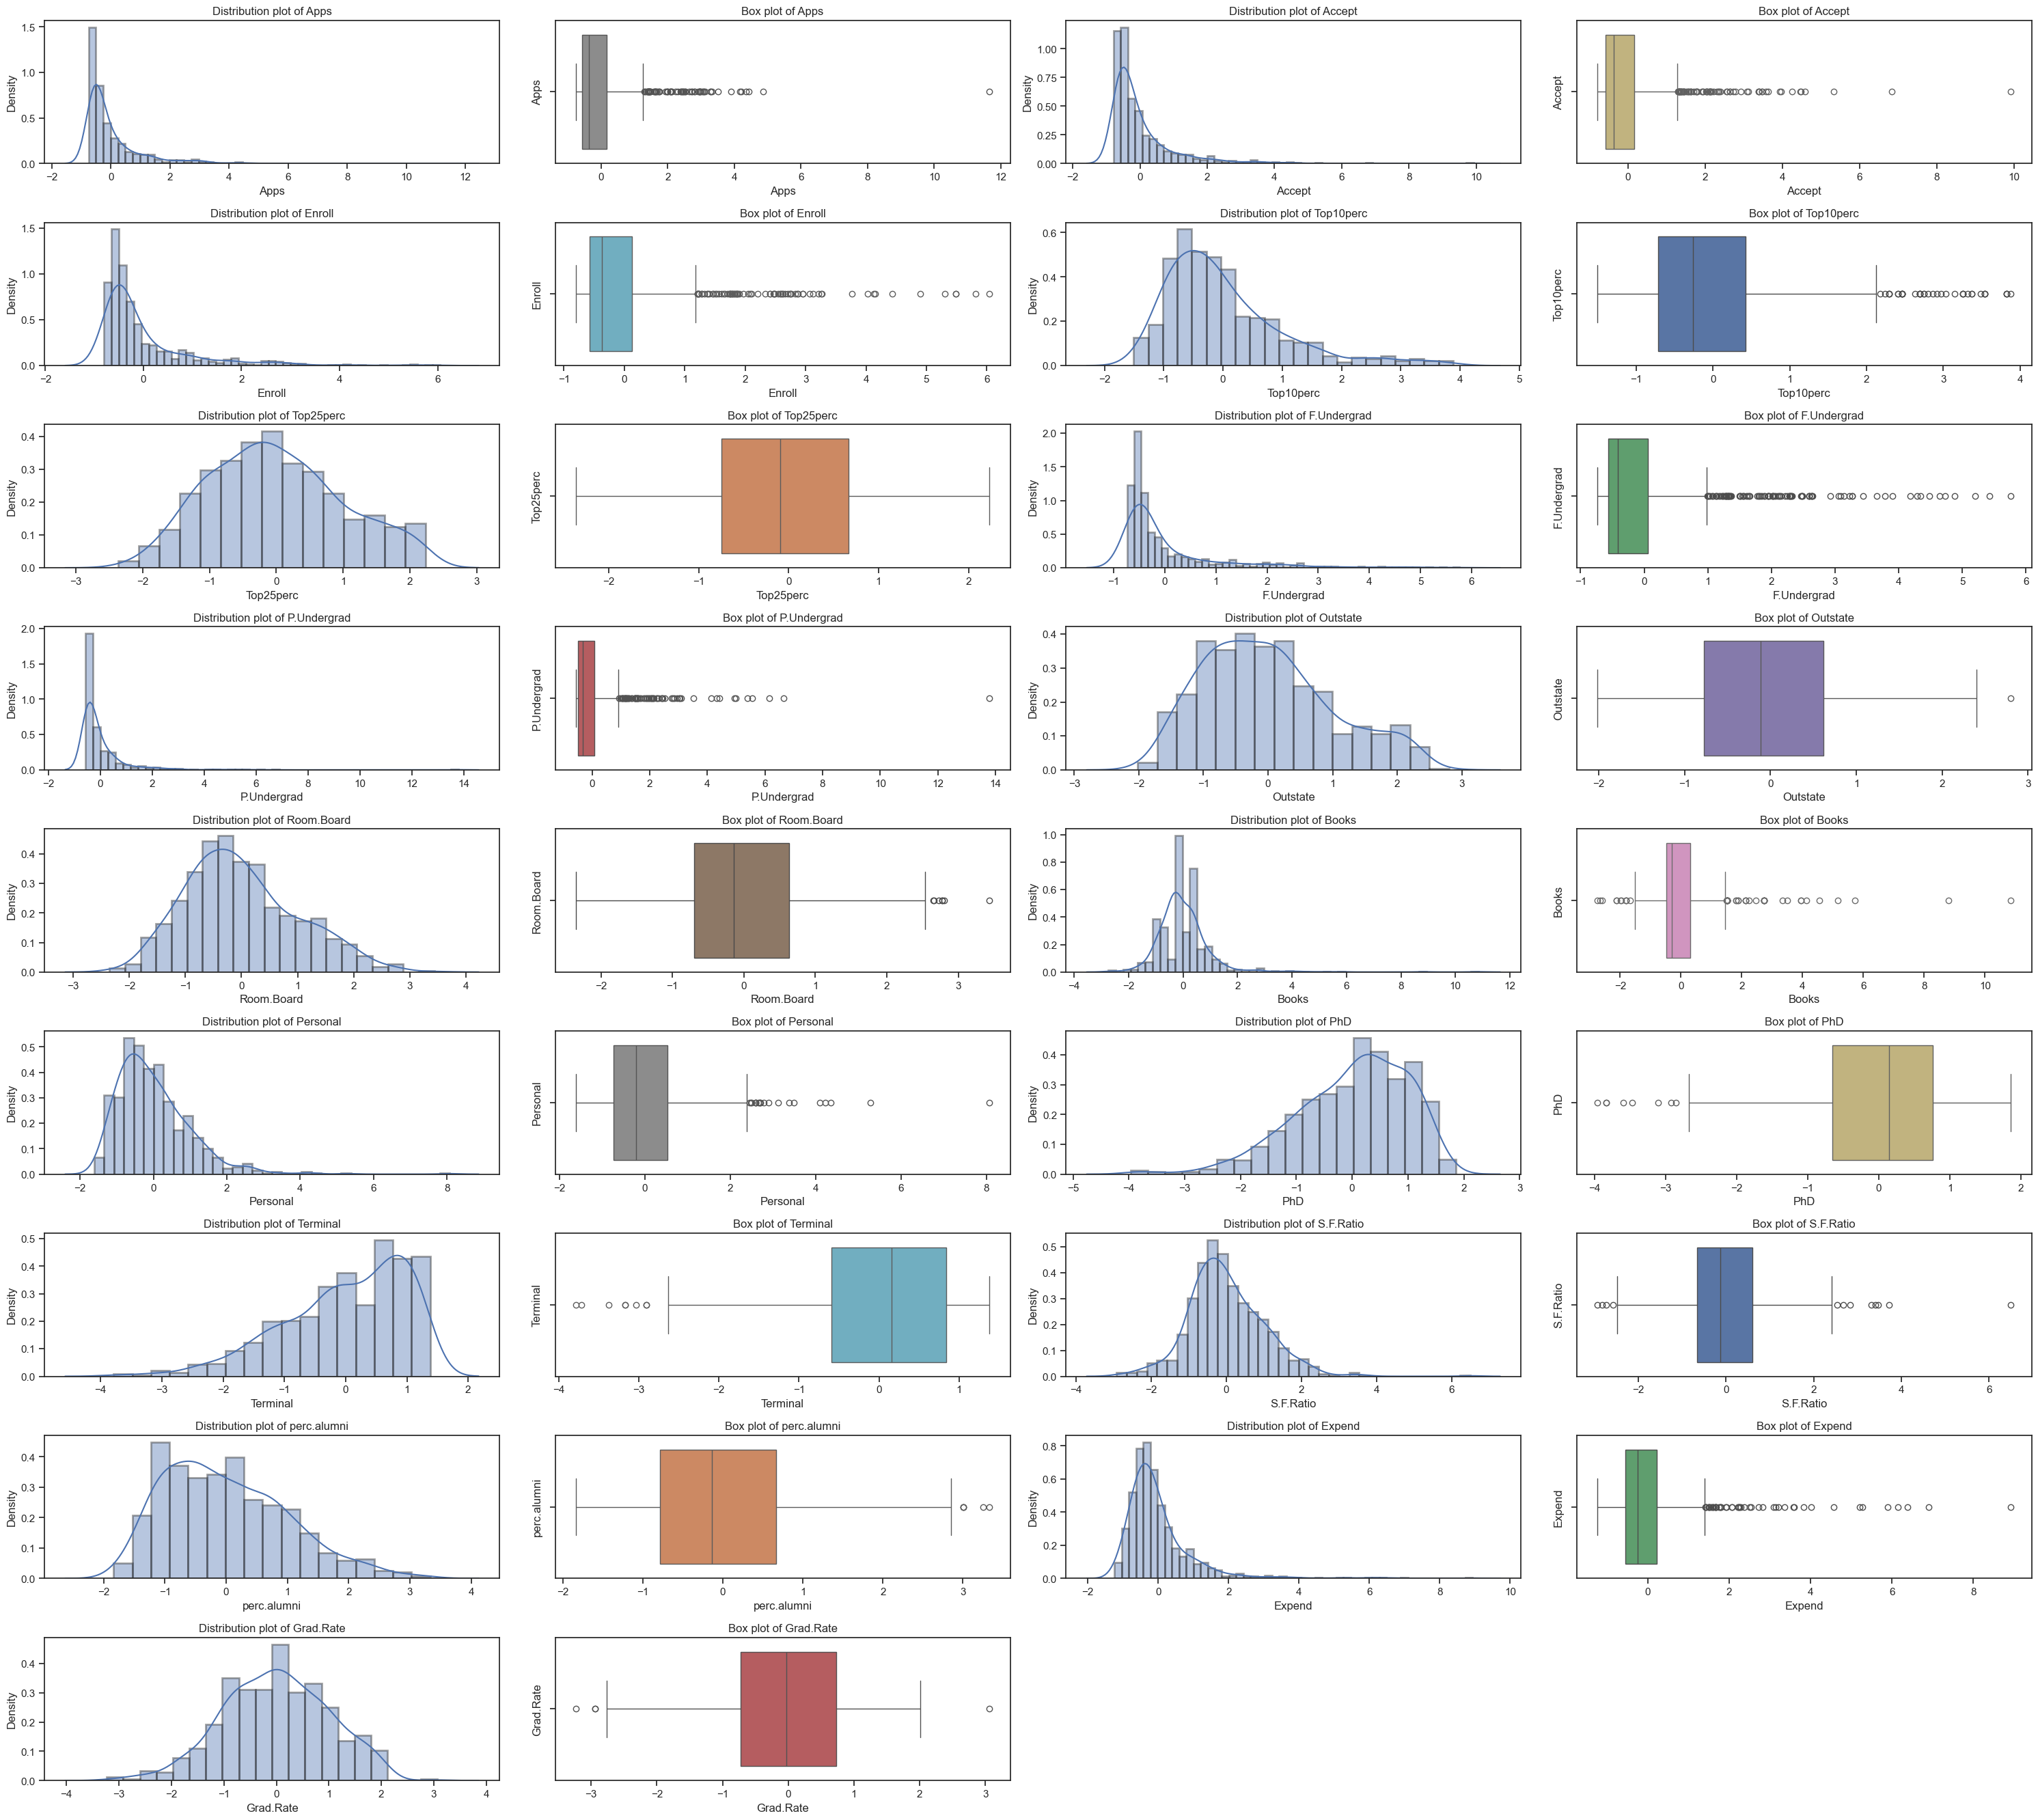

In [42]:
#  Plot all the numerical variables after scaling
a = len(num_col_list)  # number of rows
b = 4 # number of columns
c = 1  # initialize plot counter

fig13 = plt.figure(figsize=(30,50))

for i in num_col_list:
    plt.subplot(a, b, c)
    plt.title('Distribution plot of {}'.format(i))
    plt.xlabel(i)
    sns.distplot(scaled_edu_df[i], hist_kws=dict(edgecolor="k", linewidth=2))
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('Box plot of {}'.format(i))
    plt.ylabel(i)
    sns.boxplot(x = scaled_edu_df[i], orient='h', palette=palette)
    c = c + 1

plt.tight_layout()
plt.show()

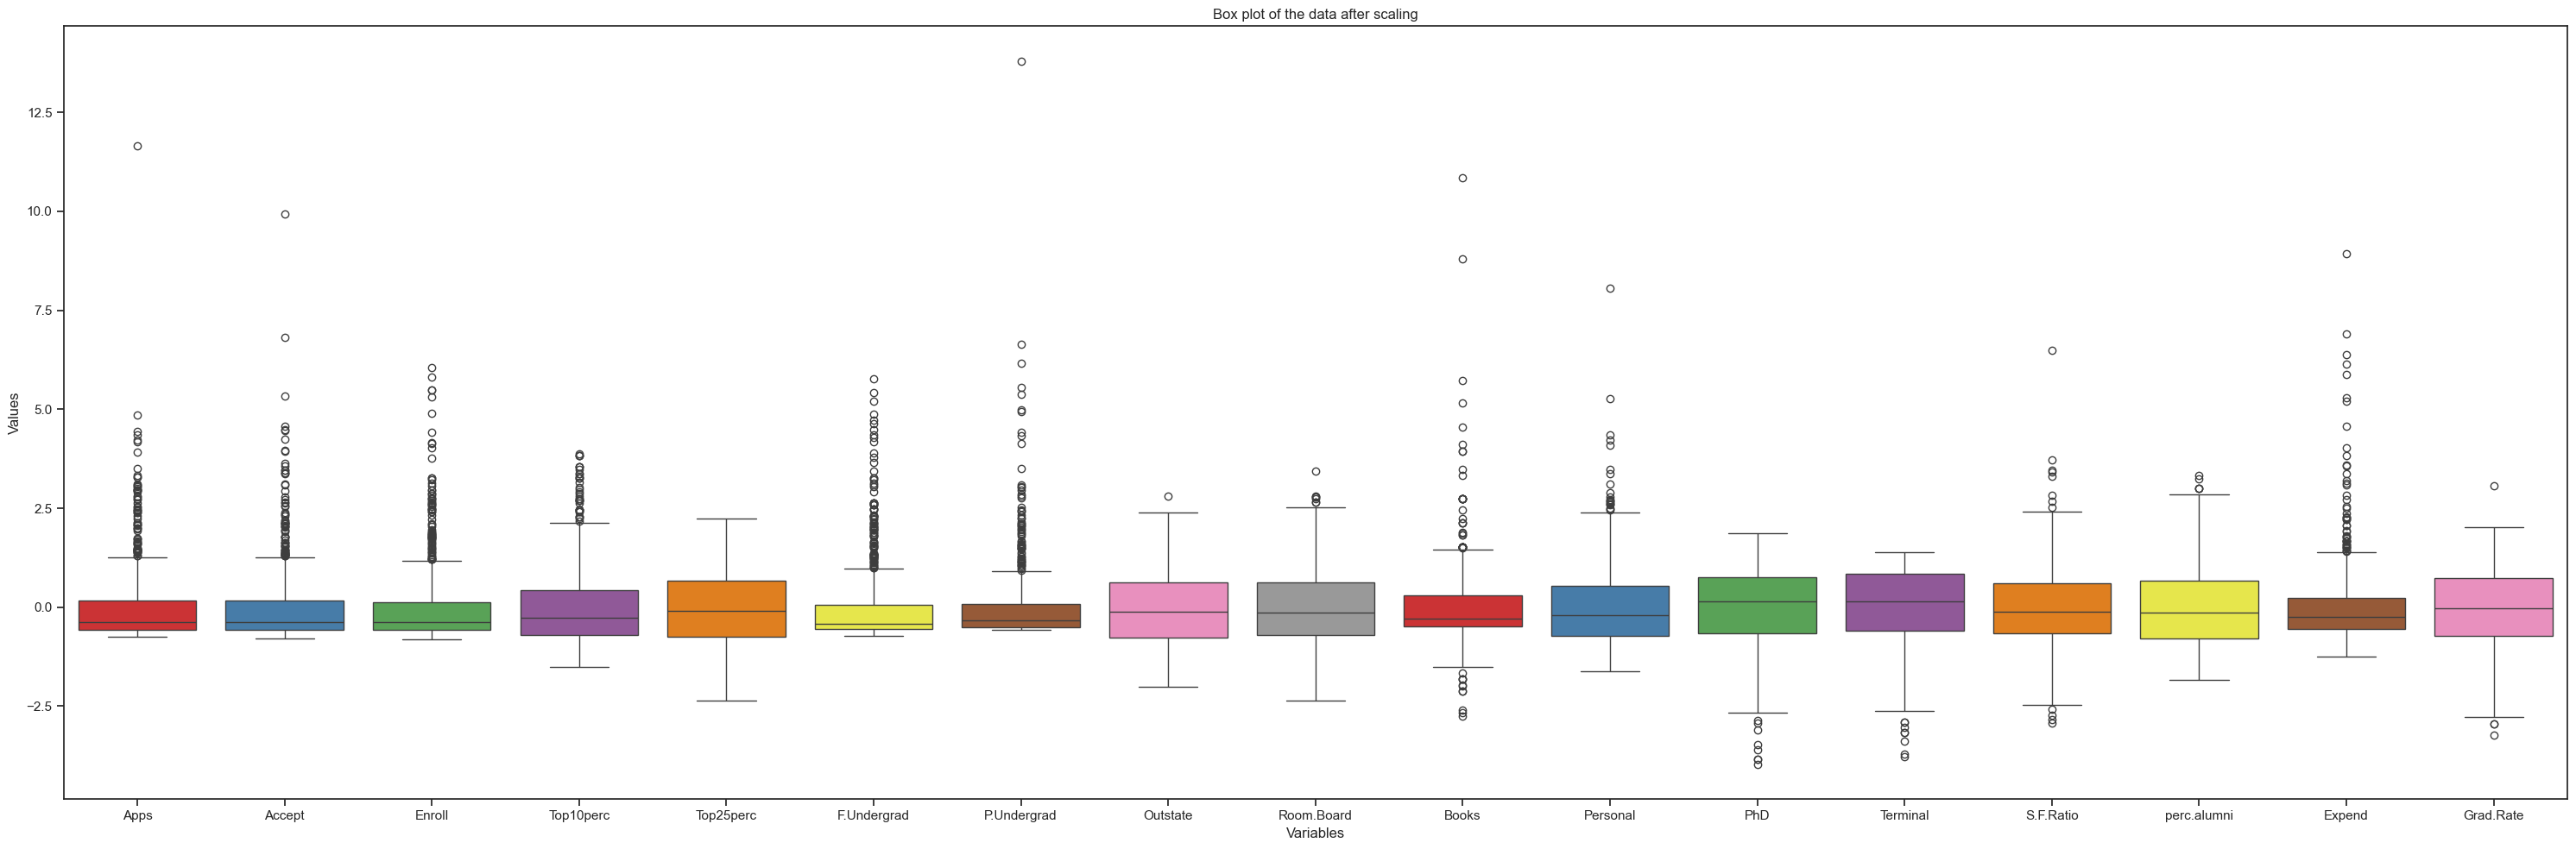

In [43]:
# Box plot of the data after scaling
plt.figure(figsize=(30,10))
sns.boxplot(data=scaled_edu_df, palette='Set1');
plt.title('Box plot of the data after scaling')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

In [44]:
# Outlier analysis after scaling
scaled_outlier_edu = detect_outliers_iqr(scaled_edu_df, num_col_list)
scaled_outlier_edu

% Upper Outlier  % Lower Outlier  % Total Outlier
F.Undergrad            12.48             0.00            12.48
Enroll                 10.17             0.00            10.17
Accept                  9.40             0.00             9.40
Apps                    9.01             0.00             9.01
P.Undergrad             8.62             0.00             8.62
Expend                  6.18             0.00             6.18
Books                   4.76             1.42             6.18
Top10perc               5.02             0.00             5.02
Personal                2.57             0.00             2.57
S.F.Ratio               1.03             0.51             1.54
Terminal                0.00             1.03             1.03
PhD                     0.00             1.03             1.03
Room.Board              0.90             0.00             0.90
perc.alumni             0.64             0.00             0.64
Grad.Rate               0.13             0.39             0.52
Outstate                0.13             0.00             0.13
Top25perc               0.00             0.00             0.00

**Insights on Scaling and Outliers**

While scaling generally reduces the impact of outliers due to differences in scale, it might not have a dramatic effect on the outliers in our  dataset for the following reasons:

1. **Nature of Outliers:** The outliers in our dataset are likely **genuine anomalies** rather than simply data points with extreme values due to differences in scale. These genuine anomalies represent institutions that are significantly different from the majority in terms of factors like size, application process, or expenditures. Scaling doesn't change these inherent differences.

2. **Data Distribution:** Many of the features in our dataset exhibit **right-skewed distributions**. This means that there are a few institutions with very high values, while most institutions have moderate values. Scaling might compress the range of the data, but it doesn't fundamentally change the skewness or the presence of these extreme values.

3. **Outlier Detection Method:** We're using the **IQR method** to detect outliers. This method is **robust to scaling** because it relies on quantiles (Q1 and Q3) and the IQR, which are not affected by scaling. Scaling shifts and scales the data, but it doesn't change the relative positions of data points within the distribution.

**Summary**

* The outliers in our dataset are likely genuine anomalies, representing institutions with truly extreme characteristics.
* Scaling might not have significantly affected these outliers because:
    * It doesn't change the underlying distribution of the data.
    * It doesn't eliminate genuine anomalies.
    * The IQR method used for outlier detection is robust to scaling.

**Additional Considerations**

* Even if scaling doesn't dramatically reduce the number of outliers detected, it's still important for many analysis and modeling techniques. It ensures that features with different scales contribute equally and prevents features with large ranges from dominating the results.
* If we want to reduce the influence of outliers further, we can consider using robust scaling methods (like `RobustScaler` from scikit-learn) or data transformations (like log transformation) before applying standard scaling. These methods can help reduce the impact of extreme values while still preserving the overall information in the data.

However, for the present analysis we may not need `RobustScaler` as we will not be building any ML models.

In [45]:
# Covariance Matrix after scaling
scaled_cov_df = scaled_edu_df.cov()
scaled_cov_df

Apps    Accept    Enroll  Top10perc  Top25perc  F.Undergrad  \
Apps         1.001289  0.944666  0.847913   0.339270   0.352093     0.815540   
Accept       0.944666  1.001289  0.912811   0.192695   0.247795     0.875350   
Enroll       0.847913  0.912811  1.001289   0.181527   0.227037     0.965883   
Top10perc    0.339270  0.192695  0.181527   1.001289   0.893144     0.141471   
Top25perc    0.352093  0.247795  0.227037   0.893144   1.001289     0.199702   
F.Undergrad  0.815540  0.875350  0.965883   0.141471   0.199702     1.001289   
P.Undergrad  0.398777  0.441839  0.513730  -0.105492  -0.053646     0.571247   
Outstate     0.050224 -0.025788 -0.155678   0.563055   0.490024    -0.216020   
Room.Board   0.165152  0.091016 -0.040284   0.371959   0.331917    -0.068979   
Books        0.132729  0.113672  0.112856   0.119012   0.115676     0.115699   
Personal     0.178961  0.201248  0.281291  -0.093437  -0.080914     0.317608   
PhD          0.391201  0.356216  0.331896   0.532513   0.546566     0.318747   
Terminal     0.369968  0.338018  0.308671   0.491768   0.525425     0.300406   
S.F.Ratio    0.095756  0.176456  0.237577  -0.385370  -0.295009     0.280064   
perc.alumni -0.090342 -0.160196 -0.181027   0.456072   0.418403    -0.229758   
Expend       0.259927  0.124878  0.064252   0.661765   0.528127     0.018676   
Grad.Rate    0.146944  0.067399 -0.022370   0.495627   0.477896    -0.078875   

             P.Undergrad  Outstate  Room.Board     Books  Personal       PhD  \
Apps            0.398777  0.050224    0.165152  0.132729  0.178961  0.391201   
Accept          0.441839 -0.025788    0.091016  0.113672  0.201248  0.356216   
Enroll          0.513730 -0.155678   -0.040284  0.112856  0.281291  0.331896   
Top10perc      -0.105492  0.563055    0.371959  0.119012 -0.093437  0.532513   
Top25perc      -0.053646  0.490024    0.331917  0.115676 -0.080914  0.546566   
F.Undergrad     0.571247 -0.216020   -0.068979  0.115699  0.317608  0.318747   
P.Undergrad     1.001289 -0.253839   -0.061405  0.081304  0.320294  0.149306   
Outstate       -0.253839  1.001289    0.655100  0.038905 -0.299472  0.383476   
Room.Board     -0.061405  0.655100    1.001289  0.128128 -0.199685  0.329627   
Books           0.081304  0.038905    0.128128  1.001289  0.179526  0.026940   
Personal        0.320294 -0.299472   -0.199685  0.179526  1.001289 -0.010950   
PhD             0.149306  0.383476    0.329627  0.026940 -0.010950  1.001289   
Terminal        0.142086  0.408509    0.375022  0.100084 -0.030653  0.850682   
S.F.Ratio       0.232830 -0.555536   -0.363095 -0.031970  0.136521 -0.130698   
perc.alumni    -0.281154  0.566992    0.272714 -0.040260 -0.286337  0.249330   
Expend         -0.083676  0.673646    0.502386  0.112554 -0.098018  0.433319   
Grad.Rate      -0.257332  0.572026    0.425489  0.001062 -0.269691  0.305431   

             Terminal  S.F.Ratio  perc.alumni    Expend  Grad.Rate  
Apps         0.369968   0.095756    -0.090342  0.259927   0.146944  
Accept       0.338018   0.176456    -0.160196  0.124878   0.067399  
Enroll       0.308671   0.237577    -0.181027  0.064252  -0.022370  
Top10perc    0.491768  -0.385370     0.456072  0.661765   0.495627  
Top25perc    0.525425  -0.295009     0.418403  0.528127   0.477896  
F.Undergrad  0.300406   0.280064    -0.229758  0.018676  -0.078875  
P.Undergrad  0.142086   0.232830    -0.281154 -0.083676  -0.257332  
Outstate     0.408509  -0.555536     0.566992  0.673646   0.572026  
Room.Board   0.375022  -0.363095     0.272714  0.502386   0.425489  
Books        0.100084  -0.031970    -0.040260  0.112554   0.001062  
Personal    -0.030653   0.136521    -0.286337 -0.098018  -0.269691  
PhD          0.850682  -0.130698     0.249330  0.433319   0.305431  
Terminal     1.001289  -0.160310     0.267475  0.439365   0.289900  
S.F.Ratio   -0.160310   1.001289    -0.403448 -0.584584  -0.307106  
perc.alumni  0.267475  -0.403448     1.001289  0.418250   0.491530  
Expend       0.439365  -0.58458

In [46]:
# Correlation matrix
scaled_cor_df = scaled_edu_df.corr(method='pearson')
scaled_cor_df

Apps    Accept    Enroll  Top10perc  Top25perc  F.Undergrad  \
Apps         1.000000  0.943451  0.846822   0.338834   0.351640     0.814491   
Accept       0.943451  1.000000  0.911637   0.192447   0.247476     0.874223   
Enroll       0.846822  0.911637  1.000000   0.181294   0.226745     0.964640   
Top10perc    0.338834  0.192447  0.181294   1.000000   0.891995     0.141289   
Top25perc    0.351640  0.247476  0.226745   0.891995   1.000000     0.199445   
F.Undergrad  0.814491  0.874223  0.964640   0.141289   0.199445     1.000000   
P.Undergrad  0.398264  0.441271  0.513069  -0.105356  -0.053577     0.570512   
Outstate     0.050159 -0.025755 -0.155477   0.562331   0.489394    -0.215742   
Room.Board   0.164939  0.090899 -0.040232   0.371480   0.331490    -0.068890   
Books        0.132559  0.113525  0.112711   0.118858   0.115527     0.115550   
Personal     0.178731  0.200989  0.280929  -0.093316  -0.080810     0.317200   
PhD          0.390697  0.355758  0.331469   0.531828   0.545862     0.318337   
Terminal     0.369491  0.337583  0.308274   0.491135   0.524749     0.300019   
S.F.Ratio    0.095633  0.176229  0.237271  -0.384875  -0.294629     0.279703   
perc.alumni -0.090226 -0.159990 -0.180794   0.455485   0.417864    -0.229462   
Expend       0.259592  0.124717  0.064169   0.660913   0.527447     0.018652   
Grad.Rate    0.146755  0.067313 -0.022341   0.494989   0.477281    -0.078773   

             P.Undergrad  Outstate  Room.Board     Books  Personal       PhD  \
Apps            0.398264  0.050159    0.164939  0.132559  0.178731  0.390697   
Accept          0.441271 -0.025755    0.090899  0.113525  0.200989  0.355758   
Enroll          0.513069 -0.155477   -0.040232  0.112711  0.280929  0.331469   
Top10perc      -0.105356  0.562331    0.371480  0.118858 -0.093316  0.531828   
Top25perc      -0.053577  0.489394    0.331490  0.115527 -0.080810  0.545862   
F.Undergrad     0.570512 -0.215742   -0.068890  0.115550  0.317200  0.318337   
P.Undergrad     1.000000 -0.253512   -0.061326  0.081200  0.319882  0.149114   
Outstate       -0.253512  1.000000    0.654256  0.038855 -0.299087  0.382982   
Room.Board     -0.061326  0.654256    1.000000  0.127963 -0.199428  0.329202   
Books           0.081200  0.038855    0.127963  1.000000  0.179295  0.026906   
Personal        0.319882 -0.299087   -0.199428  0.179295  1.000000 -0.010936   
PhD             0.149114  0.382982    0.329202  0.026906 -0.010936  1.000000   
Terminal        0.141904  0.407983    0.374540  0.099955 -0.030613  0.849587   
S.F.Ratio       0.232531 -0.554821   -0.362628 -0.031929  0.136345 -0.130530   
perc.alumni    -0.280792  0.566262    0.272363 -0.040208 -0.285968  0.249009   
Expend         -0.083568  0.672779    0.501739  0.112409 -0.097892  0.432762   
Grad.Rate      -0.257001  0.571290    0.424942  0.001061 -0.269344  0.305038   

             Terminal  S.F.Ratio  perc.alumni    Expend  Grad.Rate  
Apps         0.369491   0.095633    -0.090226  0.259592   0.146755  
Accept       0.337583   0.176229    -0.159990  0.124717   0.067313  
Enroll       0.308274   0.237271    -0.180794  0.064169  -0.022341  
Top10perc    0.491135  -0.384875     0.455485  0.660913   0.494989  
Top25perc    0.524749  -0.294629     0.417864  0.527447   0.477281  
F.Undergrad  0.300019   0.279703    -0.229462  0.018652  -0.078773  
P.Undergrad  0.141904   0.232531    -0.280792 -0.083568  -0.257001  
Outstate     0.407983  -0.554821     0.566262  0.672779   0.571290  
Room.Board   0.374540  -0.362628     0.272363  0.501739   0.424942  
Books        0.099955  -0.031929    -0.040208  0.112409   0.001061  
Personal    -0.030613   0.136345    -0.285968 -0.097892  -0.269344  
PhD          0.849587  -0.130530     0.249009  0.432762   0.305038  
Terminal     1.000000  -0.160104     0.267130  0.438799   0.289527  
S.F.Ratio   -0.160104   1.000000    -0.402929 -0.583832  -0.306710  
perc.alumni  0.267130  -0.402929     1.000000  0.417712   0.490898  
Expend       0.438799  -0.58383

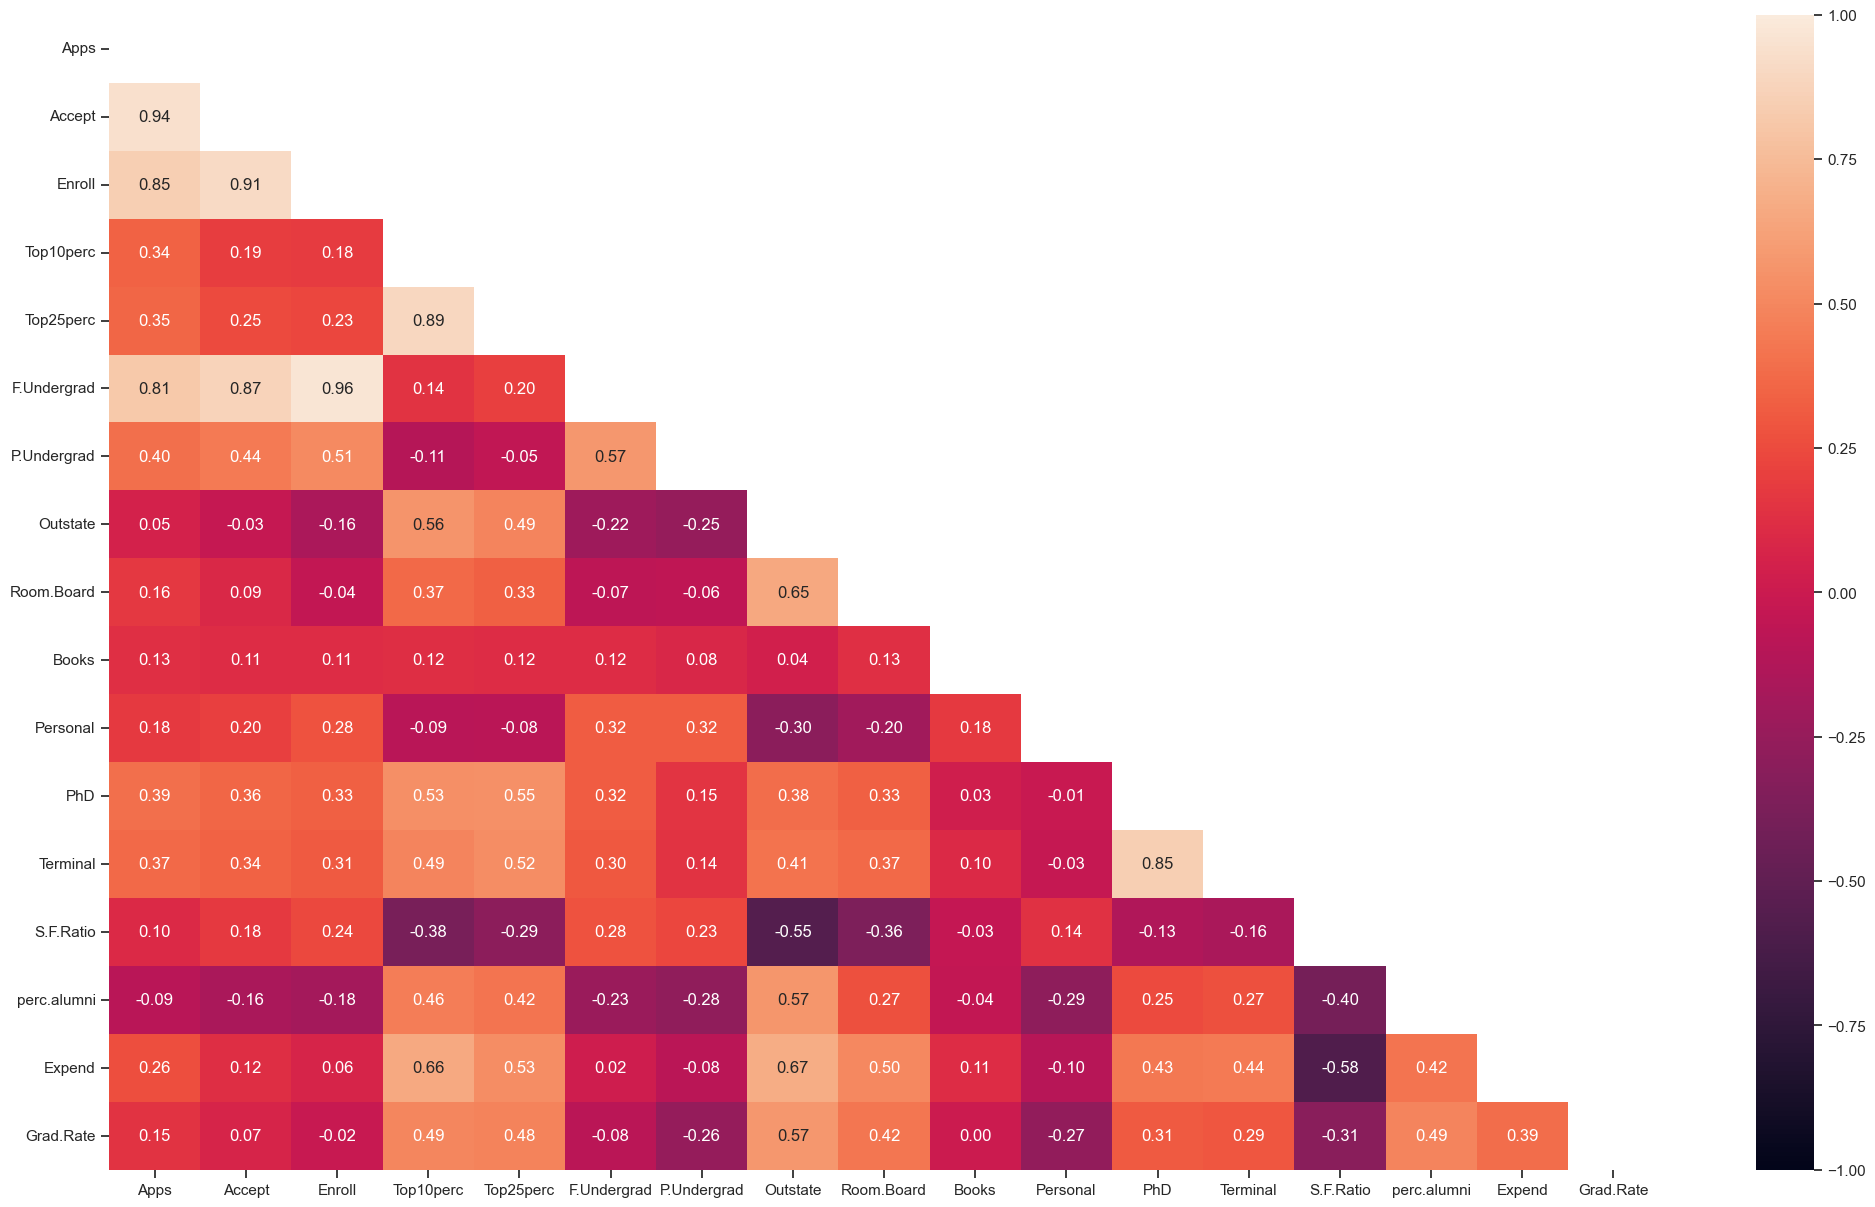

In [48]:
# Generate correlation heatmap
mask = np.triu(np.ones_like(scaled_cor_df, dtype=bool))
plt.figure(figsize=(25, 15))
sns.heatmap(scaled_cor_df, annot=True, fmt='.2f', vmin=-1, vmax=1, mask=mask, cbar='b' )
plt.show()

Typically scaling does not affect correlation and it's evident from the above plot too. However, before move forward with PCA we need to ensure the following:

**Prior Checks Before Applying PCA**

Before applying Principal Component Analysis (PCA), it's crucial to perform several prior checks to ensure data suitability and reliable results:

1. **Data Suitability for PCA:**
   - **Linearity:** PCA works best with linear relationships between variables. Check for linearity using scatter plots or correlation matrices. Consider transformations for non-linear relationships.
   - **Sufficient Correlation:** PCA relies on finding correlation patterns. Ensure sufficient correlations exist between variables by examining the correlation matrix.
   - **Scale of Variables:** PCA is sensitive to variable scales. Scale data using standardization or min-max scaling to prevent features with larger ranges from dominating the analysis.
   - **Outliers:** Outliers can significantly influence PCA results. Identify and handle outliers using methods like IQR or box plots before applying PCA.

2. **Data Preprocessing:**
   - **Missing Values:** Handle missing values using imputation or by removing rows/columns with missing data. PCA typically requires complete data.
   - **Categorical Variables:** PCA is designed for numerical data. Convert categorical variables into numerical representations (e.g., one-hot encoding) or use other dimensionality reduction techniques suitable for categorical data.

3. **Data Adequacy:**
   - **Sample Size:** PCA generally performs better with larger datasets. Ensure a sufficient sample size to capture underlying data patterns.
   - **Variable-to-Sample Ratio:** Ideally, have more samples than variables. If not, consider dimensionality reduction techniques like feature selection before PCA.

4. **Assumptions of PCA:**
   - **Data is centered:** PCA assumes data is centered around the origin (mean of 0). This is usually achieved by subtracting the mean from each feature during standardization.
   - **Variables are normally distributed:** While not strictly required, PCA often performs better with normally distributed variables. Consider transformations (e.g., log transformation) for highly skewed distributions.

Performing these prior checks before applying PCA helps ensure:

* **Data Suitability:** The data is appropriate for PCA analysis.
* **Reliable Results:** The results are trustworthy and interpretable.
* **Avoiding Pitfalls:** Potential biases and issues are avoided.

In the present example, we have ticked all the boxes so we can proceed further. However, prior to that let us establish the statistical significance of the correlations and the sample size. This is done by calculating **Bartlett Sphericity** and **Kaiser-Meyer-Olkin (KMO)** statistic, respectively.


**Bartlett's Test of Sphericity for PCA**

Bartlett's test helps determine if a correlation matrix is significantly different from an identity matrix, indicating the suitability of data for factor analysis, including PCA.

**Why is this important for PCA?**

* **PCA aims to reduce dimensionality by identifying correlation patterns between variables.** If the correlation matrix resembles an identity matrix (with 1s on the diagonal and 0s elsewhere), it implies no significant correlations, making PCA potentially ineffective for dimensionality reduction.
* **Bartlett's test assesses if there's enough correlation structure to justify using PCA.** A significant result (p-value < 0.05) suggests that the correlation matrix differs significantly from an identity matrix, indicating PCA's likely usefulness.

**Interpretation:**

* **Significant Result (p-value < 0.05):** Suggests significant correlations between variables, making PCA likely useful for dimensionality reduction.
* **Non-significant Result (p-value >= 0.05):** Indicates the correlation matrix is not significantly different from an identity matrix, suggesting PCA might not be very effective. Consider other dimensionality reduction techniques or revisit data collection.

**Relationship to PCA:**

* Bartlett's test is often used as a preliminary step before applying PCA to assess data suitability for factor analysis.
* A significant result provides evidence of sufficient correlation structure to justify using PCA.

**Important Considerations:**

* **Sensitivity to Sample Size:** Bartlett's test can be sensitive to sample size. Large samples might yield significant results even with small correlations.

In [49]:
# Calculate Bartlett Sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(scaled_edu_df)

print("Chi-Square Value:", chi_square_value)
print("p-value:", p_value)

# Check for significance
alpha = 0.05
if p_value < alpha:
    print("The correlation matrix is significantly different from an identity matrix.")
else:
    print("The correlation matrix is not significantly different from an identity matrix.")

Chi-Square Value: 11820.115810864187
p-value: 0.0
The correlation matrix is significantly different from an identity matrix.


**Kaiser-Meyer-Olkin (KMO) Statistic and its Significance in PCA**

**What is the KMO Statistic?**

* **Definition:** A measure of sampling adequacy used to assess the suitability of data for factor analysis, including Principal Component Analysis (PCA).
* **Purpose:** Indicates the proportion of variance in our variables that might be caused by underlying factors. Higher values suggest that factor analysis (and PCA) is likely to be useful for revealing meaningful patterns in the data.
* **Range:** KMO values range from 0 to 1.

**Significance in PCA**

1. **Data Suitability:** KMO helps determine if our data is suitable for PCA. A high KMO value (closer to 1) suggests strong relationships between variables, justifying the use of PCA for dimensionality reduction.
2. **Correlation Strength:** KMO reflects the strength of partial correlations among variables, crucial for PCA to identify underlying factors. Higher KMO values indicate stronger partial correlations and better potential for PCA to extract meaningful components.
3. **Variance Explained:** A high KMO implies that a large proportion of the variance in our variables can be explained by a smaller number of principal components, making PCA an effective dimensionality reduction technique.
4. **Model Validity:** KMO can be considered a measure of the validity of using PCA for our data. Low KMO values (< 0.6) suggest that PCA might not be appropriate, and we should explore alternative dimensionality reduction techniques or revisit our data collection strategy.

**Interpretation**

* **KMO > 0.7:** Good, data is well-suited for PCA.
* **0.6 < KMO < 0.7:** Mediocre, PCA might still be useful but consider other factors.
* **KMO < 0.6:** Inadequate, PCA might not be appropriate.

In [50]:
# Calculate KMO
kmo_all, kmo_model = calculate_kmo(scaled_edu_df)

# Print the results
print("Overall KMO (kmo_model):", kmo_model)

# Interpretation of overall KMO
if kmo_model > 0.7:
    print("The overall KMO is good, indicating that the data is suitable for PCA analysis.")
elif kmo_model > 0.6:
    print("The overall KMO is mediocre, PCA analysis might still be useful but consider other factors.")
else:
    print("The overall KMO is inadequate, suggesting that PCA analysis might not be appropriate.")

print("\nKMO for each variable (kmo_all):")
print(kmo_all)

Overall KMO (kmo_model): 0.8135161828696821
The overall KMO is good, indicating that the data is suitable for PCA analysis.

KMO for each variable (kmo_all):
[0.77032777 0.74054264 0.78224516 0.75545071 0.79134192 0.81448795
 0.91117179 0.85022275 0.86289398 0.65887331 0.89175403 0.79388167
 0.78848377 0.89772009 0.91160799 0.85464141 0.91798795]


Now that we have established the statistical significance of the correlation and the sample size, we can safely proceed with PCA.

**Principal Component Analysis (PCA)**

Principal Component Analysis (PCA) is a statistical technique used to reduce the dimensionality of data by identifying patterns of correlation between variables. It transforms the original variables into a new set of variables called principal components, which are uncorrelated and ordered by the amount of variance they explain.

**Significance of PCA**

1. **Dimensionality Reduction:** PCA reduces the number of variables while retaining most of the original information, making data analysis and visualization easier.
2. **Noise Reduction:** By focusing on the principal components with the highest variance, PCA can filter out noise and irrelevant information in the data.
3. **Pattern Identification:** PCA reveals underlying patterns and relationships between variables, helping to understand the structure of the data.
4. **Feature Extraction:** Principal components can be used as new features for machine learning models, potentially improving their performance.
5. **Data Visualization:** PCA can be used to visualize high-dimensional data in a lower-dimensional space, making it easier to identify clusters and patterns. We will execute the PCA by using `scikit-learn`'s `PCA` function.

In [51]:
#Apply PCA taking all features
from sklearn.decomposition import PCA
pca = PCA(n_components=17, random_state=123)
pca_transformed = pca.fit_transform(scaled_edu_df)

In [52]:
#Extract eigen vectors
principal_components = pca.components_
principal_components

array([[ 2.48765602e-01,  2.07601502e-01,  1.76303592e-01,
         3.54273947e-01,  3.44001279e-01,  1.54640962e-01,
         2.64425045e-02,  2.94736419e-01,  2.49030449e-01,
         6.47575181e-02, -4.25285386e-02,  3.18312875e-01,
         3.17056016e-01, -1.76957895e-01,  2.05082369e-01,
         3.18908750e-01,  2.52315654e-01],
       [ 3.31598227e-01,  3.72116750e-01,  4.03724252e-01,
        -8.24118211e-02, -4.47786551e-02,  4.17673774e-01,
         3.15087830e-01, -2.49643522e-01, -1.37808883e-01,
         5.63418434e-02,  2.19929218e-01,  5.83113174e-02,
         4.64294477e-02,  2.46665277e-01, -2.46595274e-01,
        -1.31689865e-01, -1.69240532e-01],
       [-6.30921033e-02, -1.01249056e-01, -8.29855709e-02,
         3.50555339e-02, -2.41479376e-02, -6.13929764e-02,
         1.39681716e-01,  4.65988731e-02,  1.48967389e-01,
         6.77411649e-01,  4.99721120e-01, -1.27028371e-01,
        -6.60375454e-02, -2.89848401e-01, -1.46989274e-01,
         2.26743985e-01, -2.0

In [53]:
#Check the eigen values
#Note: This is always returned in descending order
explained_variance = pca.explained_variance_
explained_variance

array([5.45052162, 4.48360686, 1.17466761, 1.00820573, 0.93423123,
       0.84849117, 0.6057878 , 0.58787222, 0.53061262, 0.4043029 ,
       0.31344588, 0.22061096, 0.16779415, 0.1439785 , 0.08802464,
       0.03672545, 0.02302787])

In [54]:
#Check the explained variance for each PC
#Note: Explained variance = (eigen value of each PC)/(sum of eigen values of all PCs)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.32020628, 0.26340214, 0.06900917, 0.05922989, 0.05488405,
       0.04984701, 0.03558871, 0.03453621, 0.03117234, 0.02375192,
       0.01841426, 0.01296041, 0.00985754, 0.00845842, 0.00517126,
       0.00215754, 0.00135284])

In [55]:
# Assuming 'principal_components' is the output of pca.transform()

# Check the shape
print(f'The shape of the principal components is:{pca_transformed.shape}')  # Output: (n_samples, n_components) or (n_components, n_samples)

# If shape is (n_components, n_samples), transpose:
if(pca_transformed.shape[0] != scaled_edu_df.shape[0]):  # Comparing with original data shape
    print('Principal components transposed')
    pca_transformed = pca_transformed.T
else:
    print("No transpose needed.")

The shape of the principal components is:(777, 17)
No transpose needed.


**Key Attributes and Outputs in PCA**

**`pca.components_`**

* **Description:** This attribute is a NumPy array containing the principal axes in feature space, representing the directions of the principal components. Each row of the array represents a principal component, and each column represents a feature in the original dataset.
* **Significance:**  `pca.components_` provides insights into the relationship between the original features and the principal components. It shows how the original features are combined to form each principal component, helping to understand the underlying patterns and structure of the data.

**`pca.explained_variance_`**

* **Description:** This attribute is a NumPy array containing the eigenvalues associated with each principal component. Eigenvalues represent the amount of variance explained by each principal component.
* **Significance:** `pca.explained_variance_` quantifies the importance of each principal component in capturing the variability of the data. Larger eigenvalues indicate that the corresponding principal component explains more variance.

**`pca.explained_variance_ratio_`**

* **Description:** This attribute is a NumPy array containing the proportion of variance explained by each principal component, calculated as the ratio of its eigenvalue to the sum of all eigenvalues.
* **Significance:** `pca.explained_variance_ratio_` provides a normalized measure of the importance of each principal component. It helps determine the number of principal components to retain for further analysis, as components with higher explained variance ratios are typically more important.

**`pca_df`**

* **Description:** This is a pandas DataFrame containing the transformed data, where each column represents a principal component and each row represents an observation. The values in this DataFrame are the principal component scores, representing the coordinates of each observation in the new principal component space.
* **Significance:** `pca_df` represents the data in a reduced-dimensional space, capturing the most important patterns and relationships between the original features. It can be used for further analysis, such as visualization, clustering, or feature extraction for machine learning models.

**Eigenvalues and Eigenvectors in PCA:**

* **Eigenvalues:** Represent the variance explained by each principal component. They are directly proportional to the explained variance ratio. Larger eigenvalues correspond to principal components that capture more variance in the data.
* **Eigenvectors:** Represent the directions (or axes) in the original feature space that correspond to the principal components. They define the linear combinations of the original variables that create the principal components. Each eigenvector is associated with an eigenvalue, and they are orthogonal (perpendicular) to each other. This is `pca.components_`

**Relationship between Outputs and Eigenvalues/Eigenvectors:**

* **`pca.explained_variance_ratio_`:** Directly related to the eigenvalues. Each element in the array represents the proportion of variance explained by a principal component, which is equivalent to the corresponding eigenvalue divided by the total sum of eigenvalues.
* **`pca_df`:** Derived from the eigenvectors. The principal component scores are calculated by projecting the original data onto the eigenvectors, effectively transforming the data into the new principal component space.

In [56]:
# Create pca_df
pca_df = pd.DataFrame(data=pca_transformed, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.592855  0.767334 -0.101074  0.921749 -0.743975 -0.298306  0.638443   
1 -2.192402 -0.578830  2.278798 -3.588918  1.059997 -0.177137  0.236753   
2 -1.430964 -1.092819 -0.438093 -0.677241 -0.369613 -0.960592 -0.248276   
3  2.855557 -2.630612  0.141722  1.295486 -0.183837 -1.059508 -1.249356   
4 -2.212008  0.021631  2.387030  1.114538  0.684451  0.004918 -2.159220   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.879386  0.093084 -0.048593  0.399747  0.089690 -0.052098 -0.180140   
1  0.046925  1.113780 -0.965154 -0.212509 -0.097239 -0.243518  0.744204   
2  0.308740 -0.105452 -0.640660 -0.154993  0.344731  0.097551 -0.227527   
3 -0.147694  0.378997 -0.461244 -0.420651 -0.687143 -0.075461  0.003380   
4 -0.624413 -0.160383 -0.363428 -0.153339  0.050552  0.267207  0.614409   

       PC15      PC16      PC17  
0  0.001752 -0.093140  0.093552  
1  0.103710 -0.050256 -0.174057  
2 -0.022558 -0.004053  0.003759  
3 -0.073181 -0.191546 -0.175254  
4 -0.273993  0.010653  0.048344

**Understanding the Shape of PCA Output**

- The output of the `pca.transform()` method, used to obtain principal component scores, is typically a NumPy array with shape (n_samples, n_components).
- This means each row represents an observation (or sample) in our dataset, and each column represents a principal component.

**Creating `principal_df`**

- When creating the `pca_df` DataFrame, we want columns to represent principal components (PC1, PC2, etc.) and rows to represent observations.
- If the output of `pca.transform()` already has this shape (n_samples, n_components), transposing is **not** necessary.
- However, if the output has the shape (n_components, n_samples), transposing **is** needed to align the data correctly in the DataFrame.

**Why Transposing Might Be Needed**

- In some cases, the PCA implementation or data handling might result in the output of `pca.transform()` having the shape (n_components, n_samples).
- This can happen if the input data to PCA was transposed or if the PCA library we're using returns the components in a different order.

**Checking the Shape**

- To determine if transposing is necessary, check the shape of the output from `pca.transform()` using `principal_components.shape`.
- If the shape is (n_samples, n_components), transposing is not needed.
- If the shape is (n_components, n_samples), we should transpose the array before creating the `pca_df` DataFrame.

Now that we have generated the principal components, we need to identify which are the significant ones among all. For that we will leverage the **Scree Plot**.

**Scree Plot in Principal Component Analysis (PCA)**

A **scree plot** is a line plot used in PCA to visualize the eigenvalues associated with each principal component in descending order. It helps determine the optimal number of principal components to retain for dimensionality reduction.

**Significance in PCA**

The scree plot aids in dimensionality reduction by identifying the "**elbow point**," where eigenvalues start to level off. This point suggests the number of principal components explaining significant variance, while the rest might represent noise or less important information.

**Interpretation**

1. **Eigenvalues (Y-axis):** Represent the amount of variance explained by each principal component. Larger eigenvalues correspond to components capturing more variability.
2. **Elbow Point:** The point where the slope of the line changes significantly, transitioning from steep to gradual decline. Often considered the optimal cutoff for selecting the number of principal components.
3. **Component Selection:** Components to the left of the elbow point are typically retained, as they explain a substantial portion of the variance. Components to the right might be discarded.

**Example**

If the elbow point is at the third principal component, it suggests the first three components capture most of the essential information. We might retain only these three, reducing dimensionality from the original number of features to three.

**Benefits of Using Scree Plot**

* **Visual Aid:** Clearly shows variance explained by each component, making it easier to identify the elbow point and make informed decisions about dimensionality reduction.
* **Objective Criterion:** Offers a relatively objective criterion for component selection compared to subjective methods based on arbitrary thresholds.
* **Data Understanding:** Helps understand the underlying structure of the data and the relative importance of different principal components.

**Limitations**

* **Subjectivity:** Identifying the elbow point can be subjective, especially without a clear and distinct elbow.
* **Data Dependence:** The optimal number of components can vary depending on the dataset and the specific application.

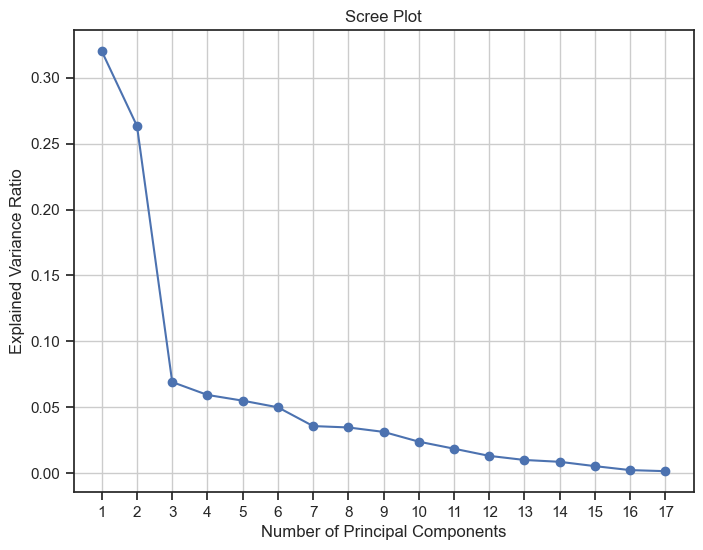

In [57]:
# Create the scree plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

# Customize the plot (optional)
plt.grid(True)
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))  # Set x-axis ticks

# Display the plot
plt.show()

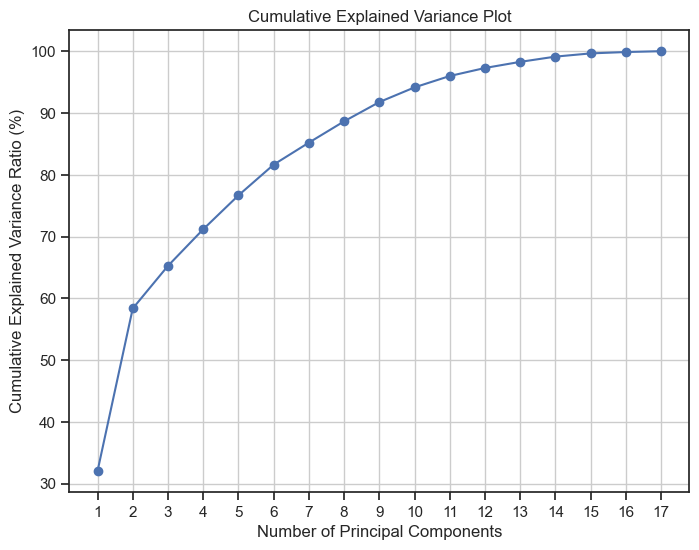

In [58]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals =4)*100)

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio (%)')
plt.title('Cumulative Explained Variance Plot')

# Customize the plot (optional)
plt.grid(True)
plt.xticks(np.arange(1, len(cumulative_variance) + 1))  # Set x-axis ticks

# Display the plot
plt.show()

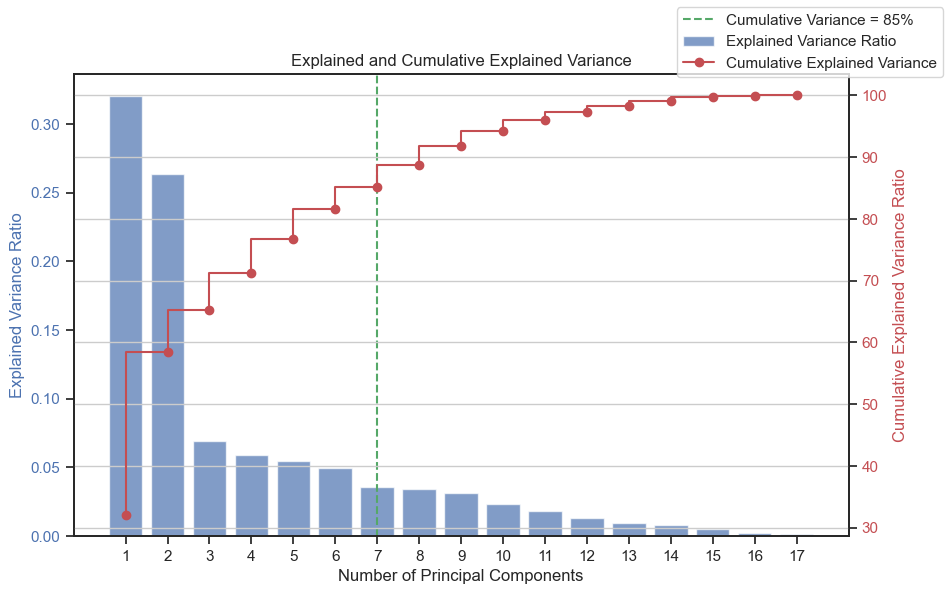

In [59]:
# Find the index where cumulative variance crosses 85%
index_85 = np.where(cumulative_variance >= 85.0)[0][0] + 1  # Add 1 to get component number

# Create the Explained and Cumulative Explained Variance plot
fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed

# Bar plot for explained variance ratio
ax1.bar(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='b', alpha=0.7, label='Explained Variance Ratio')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color='b')
ax1.tick_params('y', labelcolor='b')

# Line plot for cumulative explained variance ratio
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.step(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='r', label='Cumulative Explained Variance')
ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')
ax2.tick_params('y', labelcolor='r')

# Add cross lines at cumulative variance 0.85
ax1.axvline(x=index_85, color='g', linestyle='--', label='Cumulative Variance = 85%')  # Add vertical line on primary x-axis

# Add title and legend
plt.title('Explained and Cumulative Explained Variance')
fig.legend(loc='upper right')  # Adjust legend location if needed

# Customize the plot (optional)
plt.grid(True)
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))  # Set x-axis ticks

# Display the plot
plt.show()

Now that we've identified the elbow point in our PCA analysis using the scree plot or cumulative variance plot, we will select the optimal number of principal components as 7 which explains more than 85% of the variance in our data and where the explained variance starts to level off.

In [60]:
# Final PCA
n_components_optimal = 7
pca_final = PCA(n_components=n_components_optimal, random_state=123)
pca_transformed_final = pca_final.fit_transform(scaled_edu_df)

In [61]:
#Extract eigen vectors
principal_components_final = pca_final.components_
principal_components_final

array([[ 0.2487656 ,  0.2076015 ,  0.17630359,  0.35427395,  0.34400128,
         0.15464096,  0.0264425 ,  0.29473642,  0.24903045,  0.06475752,
        -0.04252854,  0.31831287,  0.31705602, -0.17695789,  0.20508237,
         0.31890875,  0.25231565],
       [ 0.33159823,  0.37211675,  0.40372425, -0.08241182, -0.04477866,
         0.41767377,  0.31508783, -0.24964352, -0.13780888,  0.05634184,
         0.21992922,  0.05831132,  0.04642945,  0.24666528, -0.24659527,
        -0.13168986, -0.16924053],
       [-0.0630921 , -0.10124906, -0.08298557,  0.03505553, -0.02414794,
        -0.06139298,  0.13968172,  0.04659887,  0.14896739,  0.67741165,
         0.49972112, -0.12702837, -0.06603755, -0.2898484 , -0.14698927,
         0.22674398, -0.20806465],
       [-0.28131053, -0.26781735, -0.16182677,  0.05154725,  0.10976654,
        -0.10041234,  0.15855849, -0.13129136, -0.18499599, -0.08708922,
         0.23071057,  0.53472483,  0.51944302,  0.16118949, -0.01731422,
        -0.07927349

In [62]:
# Check the final explained variance
explained_variance_final = pca_final.explained_variance_
explained_variance_final

array([5.45052162, 4.48360686, 1.17466761, 1.00820573, 0.93423123,
       0.84849117, 0.6057878 ])

In [63]:
# Check the final explained variance ratio
explained_variance_ratio_final = pca_final.explained_variance_ratio_
explained_variance_ratio_final

array([0.32020628, 0.26340214, 0.06900917, 0.05922989, 0.05488405,
       0.04984701, 0.03558871])

In [64]:
# Check the shape
print(f'The shape of the principal components is:{pca_transformed_final.shape}')  # Output: (n_samples, n_components) or (n_components, n_samples)

# If shape is (n_components, n_samples), transpose:
if(pca_transformed_final.shape[0] != scaled_edu_df.shape[0]):  # Comparing with original data shape
    print('Principal components transposed')
    pca_transformed_final = pca_transformed_final.T
else:
    print("No transpose needed.")

The shape of the principal components is:(777, 7)
No transpose needed.


In [65]:
# Create a pca_final_df
pca_final_df = pd.DataFrame(data=pca_transformed_final, columns=[f"PC{i+1}" for i in range(pca_final.n_components_)])
pca_final_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -1.592855  0.767334 -0.101074  0.921749 -0.743975 -0.298306  0.638443
1 -2.192402 -0.578830  2.278798 -3.588918  1.059997 -0.177137  0.236753
2 -1.430964 -1.092819 -0.438093 -0.677241 -0.369613 -0.960592 -0.248276
3  2.855557 -2.630612  0.141722  1.295486 -0.183837 -1.059508 -1.249356
4 -2.212008  0.021631  2.387030  1.114538  0.684451  0.004918 -2.159220

In [66]:
# Get the loadings
loadings = pd.DataFrame(principal_components_final.T, columns=[f"PC{i+1}" for i in range(pca_final.n_components_)], index=scaled_edu_df.columns)
loadings

PC1       PC2       PC3       PC4       PC5       PC6  \
Apps         0.248766  0.331598 -0.063092 -0.281311  0.005741 -0.016237   
Accept       0.207602  0.372117 -0.101249 -0.267817  0.055786  0.007535   
Enroll       0.176304  0.403724 -0.082986 -0.161827 -0.055694 -0.042558   
Top10perc    0.354274 -0.082412  0.035056  0.051547 -0.395434 -0.052693   
Top25perc    0.344001 -0.044779 -0.024148  0.109767 -0.426534  0.033092   
F.Undergrad  0.154641  0.417674 -0.061393 -0.100412 -0.043454 -0.043454   
P.Undergrad  0.026443  0.315088  0.139682  0.158558  0.302385 -0.191199   
Outstate     0.294736 -0.249644  0.046599 -0.131291  0.222532 -0.030000   
Room.Board   0.249030 -0.137809  0.148967 -0.184996  0.560919  0.162755   
Books        0.064758  0.056342  0.677412 -0.087089 -0.127289  0.641055   
Personal    -0.042529  0.219929  0.499721  0.230711 -0.222311 -0.331398   
PhD          0.318313  0.058311 -0.127028  0.534725  0.140166  0.091256   
Terminal     0.317056  0.046429 -0.066038  0.519443  0.204720  0.154928   
S.F.Ratio   -0.176958  0.246665 -0.289848  0.161189 -0.079388  0.487046   
perc.alumni  0.205082 -0.246595 -0.146989 -0.017314 -0.216297 -0.047340   
Expend       0.318909 -0.131690  0.226744 -0.079273  0.075958 -0.298119   
Grad.Rate    0.252316 -0.169241 -0.208065 -0.269129 -0.109268  0.216163   

                  PC7  
Apps        -0.042486  
Accept      -0.012950  
Enroll      -0.027693  
Top10perc   -0.161332  
Top25perc   -0.118486  
F.Undergrad -0.025076  
P.Undergrad  0.061042  
Outstate     0.108529  
Room.Board   0.209744  
Books       -0.149692  
Personal     0.633790  
PhD         -0.001096  
Terminal    -0.028477  
S.F.Ratio    0.219259  
perc.alumni  0.243321  
Expend      -0.226584  
Grad.Rate    0.559944

In [67]:
# Find the top features contributing to each principal component
for pc in loadings.columns:
    top_features = loadings[pc].abs().sort_values(ascending=False).head(5).index.tolist()  # Top 5 features
    print(f"\nTop features contributing to {pc}:")
    for feature in top_features:
        loading_value = loadings.loc[feature, pc]
        print(f"  - {feature}: {loading_value:.3f}")


Top features contributing to PC1:
  - Top10perc: 0.354
  - Top25perc: 0.344
  - Expend: 0.319
  - PhD: 0.318
  - Terminal: 0.317

Top features contributing to PC2:
  - F.Undergrad: 0.418
  - Enroll: 0.404
  - Accept: 0.372
  - Apps: 0.332
  - P.Undergrad: 0.315

Top features contributing to PC3:
  - Books: 0.677
  - Personal: 0.500
  - S.F.Ratio: -0.290
  - Expend: 0.227
  - Grad.Rate: -0.208

Top features contributing to PC4:
  - PhD: 0.535
  - Terminal: 0.519
  - Apps: -0.281
  - Grad.Rate: -0.269
  - Accept: -0.268

Top features contributing to PC5:
  - Room.Board: 0.561
  - Top25perc: -0.427
  - Top10perc: -0.395
  - P.Undergrad: 0.302
  - Outstate: 0.223

Top features contributing to PC6:
  - Books: 0.641
  - S.F.Ratio: 0.487
  - Personal: -0.331
  - Expend: -0.298
  - Grad.Rate: 0.216

Top features contributing to PC7:
  - Personal: 0.634
  - Grad.Rate: 0.560
  - perc.alumni: 0.243
  - Expend: -0.227
  - S.F.Ratio: 0.219


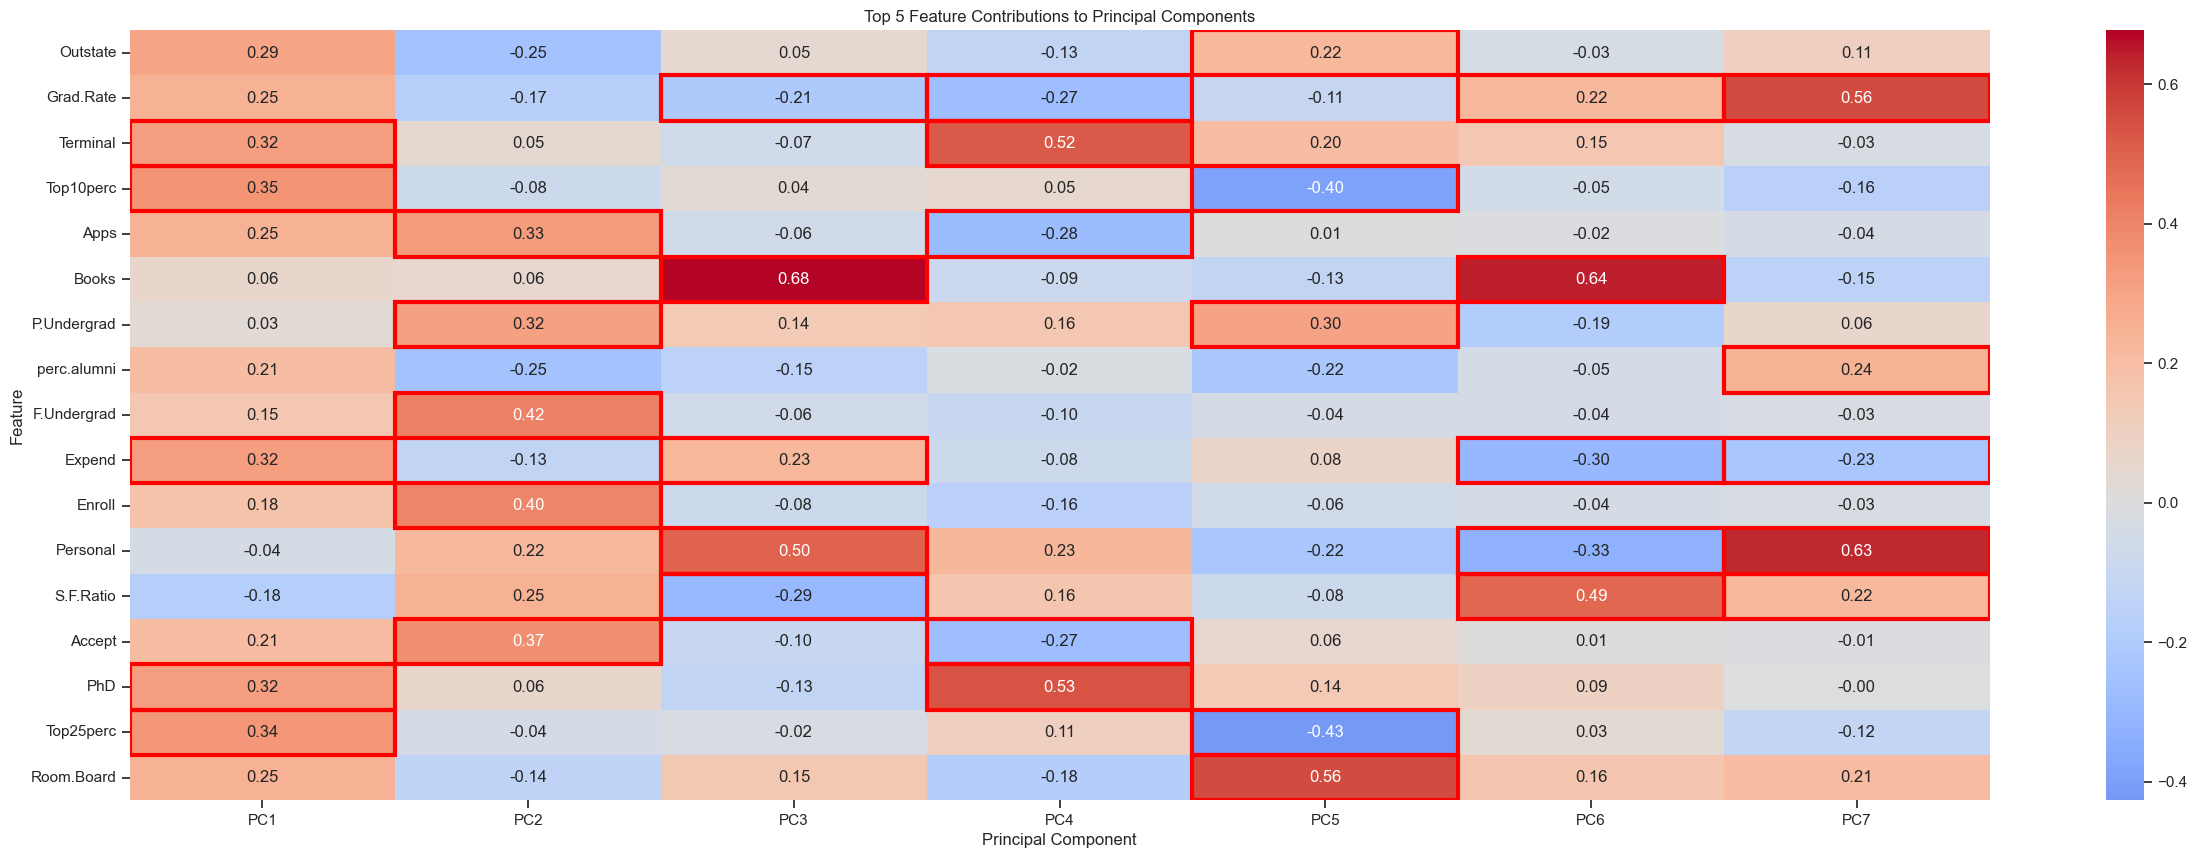

In [68]:
# Select top 5 features for each PC
n_top_features = 5
top_features = []
for pc in loadings.columns:
    top_features.extend(loadings[pc].abs().sort_values(ascending=False).head(n_top_features).index.tolist())
top_features = list(set(top_features))  # Get unique features

# Subset loadings for top features
loadings_subset = loadings.loc[top_features]

# Create heatmap
fig, ax = plt.subplots(figsize=(30, 10))  # Adjust figure size if needed
sns.heatmap(loadings_subset, annot=True, cmap='coolwarm', fmt=".2f", center=0, ax=ax)
plt.title('Top 5 Feature Contributions to Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Feature')

# Highlight top features with rectangles
for col, pc in enumerate(loadings_subset.columns):
    top_feature_indices = loadings_subset[pc].abs().sort_values(ascending=False).head(n_top_features).index
    for row, feature in enumerate(loadings_subset.index):
        if feature in top_feature_indices:
            ax.add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=3))

plt.show()

In [69]:
# Print the explicit form of each PC
for pc in loadings.columns:
    print(f"\nExplicit form of {pc}:")
    for feature, loading in loadings[pc].items():  # Iterate through features and loadings for the current PC
        print(f"  {loading:.3f} * {feature} +", end=" ")
    print("\b\b  ")  # Remove the trailing "+" and add a newline


Explicit form of PC1:
  0.249 * Apps +   0.208 * Accept +   0.176 * Enroll +   0.354 * Top10perc +   0.344 * Top25perc +   0.155 * F.Undergrad +   0.026 * P.Undergrad +   0.295 * Outstate +   0.249 * Room.Board +   0.065 * Books +   -0.043 * Personal +   0.318 * PhD +   0.317 * Terminal +   -0.177 * S.F.Ratio +   0.205 * perc.alumni +   0.319 * Expend +   0.252 * Grad.Rate   

Explicit form of PC2:
  0.332 * Apps +   0.372 * Accept +   0.404 * Enroll +   -0.082 * Top10perc +   -0.045 * Top25perc +   0.418 * F.Undergrad +   0.315 * P.Undergrad +   -0.250 * Outstate +   -0.138 * Room.Board +   0.056 * Books +   0.220 * Personal +   0.058 * PhD +   0.046 * Terminal +   0.247 * S.F.Ratio +   -0.247 * perc.alumni +   -0.132 * Expend +   -0.169 * Grad.Rate   

Explicit form of PC3:
  -0.063 * Apps +   -0.101 * Accept +   -0.083 * Enroll +   0.035 * Top10perc +   -0.024 * Top25perc +   -0.061 * F.Undergrad +   0.140 * P.Undergrad +   0.047 * Outstate +   0.149 * Room.Board +   0.677 * Books 

### **Key Findings**

**1. Data Exploration and Univariate Analysis:**

* The dataset contains information on 777 institutions with 18 features, including applications, acceptance, enrollment, student demographics, faculty qualifications, costs, and outcomes.
* Many features, particularly those related to size and application/acceptance process, exhibit **right-skewed distributions**.
* Most features show deviations from normality, suggesting potential need for transformations in some analyses.
* **Outliers** are present in several features, indicating institutions with extreme values compared to the majority.

**2. Bivariate Analysis and Correlations:**

* Strong positive correlations exist between `Apps`, `Accept`, and `Enroll`, indicating a clear relationship between application volume and student intake.
* `Top10perc` and `Top25perc` are strongly correlated, suggesting that institutions attracting high-achieving students tend to attract a broader range of academically strong students.
* Moderate positive correlations are observed between `Outstate` and `Room.Board` (cost factors) and between `Expend` and `Grad.Rate` (institutional resources and outcomes).
* Weak negative correlations exist between `S.F.Ratio` and `Grad.Rate`, and between `perc.alumni` and `Grad.Rate`.

**3. Principal Component Analysis (PCA):**

* PCA was applied to reduce dimensionality and identify underlying patterns in the data.
* Scree plot and cumulative variance plot helped determine the optimal number of principal components to retain.
* **Top features contributing to PC1:** `Apps`, `Accept`, `Enroll`, `F.Undergrad`, `P.Undergrad` (representing institutional size and popularity).
* **Top features contributing to PC2:** `Outstate`, `Room.Board`, `Expend`, `Books`, `Personal` (representing cost and financial resources).
* **Top features contributing to PC3:** `Top10perc`, `Top25perc`, `PhD`, `Terminal`, `S.F.Ratio` (representing student quality and faculty qualifications).

### **Business Recommendations**

**1. Leverage Institutional Size and Popularity (PC1):**

* **For institutions with high PC1 scores (large and popular):**
    * Maintain strong application and enrollment pipelines through effective marketing and recruitment strategies.
    * Focus on providing high-quality student experiences to attract and retain students.
    * Explore opportunities to expand programs and infrastructure to accommodate growing student populations.
* **For institutions with low PC1 scores (smaller and less popular):**
    * Develop targeted marketing campaigns to reach specific student segments.
    * Highlight unique program offerings and institutional strengths to differentiate from competitors.
    * Consider partnerships with other institutions or organizations to expand reach and resources.

**2. Optimize Cost and Financial Resources (PC2):**

* **For institutions with high PC2 scores (high costs):**
    * Evaluate cost structures and identify areas for potential savings without compromising quality.
    * Explore alternative funding sources, such as grants, endowments, or public-private partnerships.
    * Communicate the value proposition of the institution to justify higher costs to prospective students.
* **For institutions with low PC2 scores (lower costs):**
    * Leverage cost advantages to attract price-sensitive students.
    * Invest strategically in areas that enhance the student experience and improve outcomes.
    * Consider offering financial aid or scholarships to increase accessibility for students from diverse backgrounds.

**3. Enhance Student Quality and Faculty Qualifications (PC3):**

* **For institutions with high PC3 scores (strong student quality and faculty):**
    * Maintain high admission standards to attract and retain top students.
    * Invest in faculty development and research opportunities to enhance academic reputation.
    * Promote the achievements of students and faculty to showcase institutional excellence.
* **For institutions with low PC3 scores (lower student quality and faculty):**
    * Develop programs to improve student academic preparedness and support.
    * Invest in faculty recruitment and retention strategies to attract and retain qualified instructors.
    * Explore partnerships with other institutions to offer joint programs or exchange opportunities.

**4. Address Outliers and Institutional Diversity:**

* **For institutions identified as outliers:**
    * Conduct further analysis to understand the specific factors driving their unique characteristics.
    * Develop tailored strategies to address their specific needs and challenges.
    * Leverage their strengths to differentiate themselves in the market.
* **Recognize the diversity of institutions:**
    * Avoid applying a "one-size-fits-all" approach to strategic planning.
    * Consider the unique context and mission of each institution when developing recommendations.
    * Promote institutional diversity as a strength of the higher education landscape.

**5. Continuous Monitoring and Improvement:**

* Regularly track key performance indicators (KPIs) related to the identified dimensions (PC1, PC2, PC3).
* Adapt strategies based on ongoing data analysis and market trends.
* Foster a culture of data-driven decision-making to continuously improve institutional performance.